In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress, spearmanr
import glob
import json
import country_converter as coco
from datetime import datetime, timedelta
import requests
import geopandas as gpd
from seaborn.utils import ci
import colorcet as cc
import os

sns.set_context('poster')
custom_palette = ['#1b9e77','#7570b3','#d95f02']

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
base_path = './figures/'  # set for saving figures

In [3]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

# Load 

In [7]:
df = pd.read_excel('./self_citation_data.xlsx')
num_topics = 13  # this particular .csv file was based on 13 topics


# print quantiles of self-citation rates
df.groupby(['SC Type'], as_index=False)['sc_rate'].agg([percentile(.01), percentile(.05),
                                            percentile(.1), percentile(.25),
                                            percentile(.5), percentile(.75),
                                            percentile(.90), percentile(.95),
                                            percentile(.99)])



/home/mjr239/anaconda3/envs/sc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,percentile_01,percentile_05,percentile_10,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,percentile_99
SC Type,,,,,,,,,
Any,0.0,0.0,0.02381,0.066667,0.135135,0.227273,0.333333,0.411765,0.583333
FA,0.0,0.0,0.00000,0.000000,0.028571,0.076923,0.150000,0.208333,0.357143
LA,0.0,0.0,0.00000,0.024390,0.071429,0.137931,0.219512,0.282051,0.419355


# Bootstrap for confidence intervals

The below cell may take a while to run, so you can skip to the step below where we load the pre-generated bootstrap results

In [7]:
nboot = 1000

# initialize some bootstrap things
# Descriptive stats - overall, neurology, neuroscience, psychiatry sc rate
fa_recent_sc = np.zeros((nboot, 4))
la_recent_sc = np.zeros((nboot, 4))
any_recent_sc = np.zeros((nboot, 4))

# Figure 1 - over t2-s2.0-0000754856ime
r_boot = np.zeros((nboot, 3))
m_boot = np.zeros((nboot, 3))
sc_rates = np.zeros((nboot, 21, 3))

# Figure 2 - academic ages, [age, sc rate]
s = df[df.Year.isin([2016, 2017, 2018, 2019, 2020])].ac_age.value_counts()  # s for set
ac_age_to_keep = np.arange(0, 39)
fa_ac_age_sc = np.zeros((nboot, len(ac_age_to_keep)))
la_ac_age_sc = np.zeros((nboot, len(ac_age_to_keep)))
fa_ac_age_sc_normed = np.zeros((nboot, len(ac_age_to_keep)))
la_ac_age_sc_normed = np.zeros((nboot, len(ac_age_to_keep)))

# Figure 4 - topics
# topic_assignments = pd.read_csv('/content/gdrive/MyDrive/MINDS_lab/self_citation/notebooks/topic_model/lda_results_' + str(num_topics) + '.csv')
topic_fa_sc = np.zeros((nboot, num_topics))
topic_la_sc = np.zeros((nboot, num_topics))
topic_any_sc = np.zeros((nboot, num_topics))

# Figure 5 - gender
perc_female_fa_la_topic = np.zeros((nboot, num_topics, 2))
topic_gender_sc_fa_female = np.zeros((nboot, num_topics))
topic_gender_sc_la_female = np.zeros((nboot, num_topics))
topic_gender_sc_fa_male = np.zeros((nboot, num_topics))
topic_gender_sc_la_male = np.zeros((nboot, num_topics))
time_gender_sc_fa_female = np.zeros((nboot, 21))  # 21 yrs
time_gender_sc_la_female = np.zeros((nboot, 21))  # 21 yrs
time_gender_sc_fa_male = np.zeros((nboot, 21))  # 21 yrs
time_gender_sc_la_male = np.zeros((nboot, 21))  # 21 yrs
time_gender_proportion_fa_female = np.zeros((nboot, 21))
time_gender_proportion_fa_male = np.zeros((nboot, 21))
time_gender_proportion_la_female = np.zeros((nboot, 21))
time_gender_proportion_la_male = np.zeros((nboot, 21))
ac_age_gender_sc_female = np.zeros((nboot, len(ac_age_to_keep))) 
ac_age_gender_sc_male = np.zeros((nboot, len(ac_age_to_keep)))
num_papers_sc_female = []
num_papers_sc_male = []
num_papers_by_ac_age_female =[]; num_papers_by_ac_age_male = []
num_papers_groups = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500]
num_papers_sc_groups_female = np.zeros((nboot, len(num_papers_groups)))
num_papers_sc_groups_male = np.zeros((nboot, len(num_papers_groups)))

# Countries - specify which to keep
s = df[df['SC Type']=='FA']['affil_country'].value_counts()
fa_countries_to_keep = list(s[s>=50].index)
fa_countries_to_keep = [country for country in fa_countries_to_keep if country!='Error']
fa_countries_to_keep.sort()
s = df[df['SC Type']=='LA']['affil_country'].value_counts()
la_countries_to_keep = list(s[s>=50].index)
la_countries_to_keep = [country for country in la_countries_to_keep if country!='Error']
fa_sc_rate_country = np.zeros((nboot, len(fa_countries_to_keep)))
la_sc_rate_country = np.zeros((nboot, len(la_countries_to_keep)))
fa_numpapers_country = np.zeros((nboot, len(fa_countries_to_keep)))
la_numpapers_country = np.zeros((nboot, len(la_countries_to_keep)))
la_countries_to_keep.sort()

In [8]:
# main boostrap loop
for seed in tqdm(range(nboot)):

    # bootstrap on exchangeability blocks
    np.random.seed(seed)
    eb_boot = np.random.choice(df['eb'].unique(), size=len(df['eb'].unique()), replace=True)
    df_boot = df[df['eb'].isin(eb_boot)].reset_index(drop=True)


    ########################### Descriptive stats (most recent year: 2020) ################################  
    fields = ['Neurology', 'Neuroscience', 'Psychiatry']
    # first for all fields
    df_recent = df_boot[(df_boot.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_boot['field'].isin(fields))]
    df_recent_summary = df_recent.groupby(['field', 'SC Type'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
    df_recent_summary['sc_rate'] = df_recent_summary['sc_count'] / df_recent_summary['numref']

    # for overall sc rates
    fa_recent_sc[seed, 0] = df_recent_summary[df_recent_summary['SC Type']=='FA']['sc_count'].sum() / df_recent_summary[df_recent_summary['SC Type']=='FA']['numref'].sum()
    la_recent_sc[seed, 0] = df_recent_summary[df_recent_summary['SC Type']=='LA']['sc_count'].sum() / df_recent_summary[df_recent_summary['SC Type']=='LA']['numref'].sum()
    any_recent_sc[seed, 0] = df_recent_summary[df_recent_summary['SC Type']=='Any']['sc_count'].sum() / df_recent_summary[df_recent_summary['SC Type']=='Any']['numref'].sum()

    # rates by field
    for i, field in enumerate(fields):
        fa_recent_sc[seed, i+1] = df_recent_summary[(df_recent_summary.field==field) & (df_recent_summary['SC Type']=='FA')]['sc_rate']
        la_recent_sc[seed, i+1] = df_recent_summary[(df_recent_summary.field==field) & (df_recent_summary['SC Type']=='LA')]['sc_rate']
        any_recent_sc[seed, i+1] = df_recent_summary[(df_recent_summary.field==field) & (df_recent_summary['SC Type']=='Any')]['sc_rate']


    ########################### SC Over time ###################################
    df_year_sum_all = df_boot.groupby(["Year", "SC Type"]).agg({"numref": "sum", "sc_count":"sum"})
    df_year_sum_all['sc_rate'] = df_year_sum_all['sc_count'] / df_year_sum_all['numref']
    df_year_sum_all = df_year_sum_all.sort_values('Year').reset_index()
    df_year_sum_all

    # assign self-citation rates over time
    sc_rates[seed, :, 0] = df_year_sum_all[df_year_sum_all['SC Type']=='FA']['sc_rate']
    sc_rates[seed, :, 1] = df_year_sum_all[df_year_sum_all['SC Type']=='LA']['sc_rate']
    sc_rates[seed, :, 2] = df_year_sum_all[df_year_sum_all['SC Type']=='Any']['sc_rate']

    # calculate correlation (and slope) between year and self-citation rates
    for auth_idx, auth_type in enumerate(['FA', 'LA', 'Any']):
        df_tmp = df_year_sum_all[df_year_sum_all['SC Type']==auth_type]
        r_boot[seed, auth_idx] = df_tmp['sc_rate'].corr(df_tmp['Year']) 
        regr = linregress(df_tmp['Year'], df_tmp['sc_rate'])
        m_boot[seed, auth_idx] = regr.slope

    ########################### academic age (include only last 5 years: 2016-2020) ###################################
    df_ac_age = df_boot[(df_boot.Year.isin([2016, 2017, 2018, 2019, 2020]))  & (df_boot.ac_age.isin(ac_age_to_keep))]
    df_ac_age_summary = df_ac_age.groupby(['SC Type', 'ac_age']).agg({"numref": "sum", "sc_count":"sum", "numpapers":"sum",
                                                                     "papers_before_by_date":"sum"})
    df_ac_age_summary = df_ac_age_summary.sort_values('ac_age').reset_index()
    df_ac_age_summary['sc_rate'] = df_ac_age_summary['sc_count'] / df_ac_age_summary['numref']
    fa_ac_age_sc[seed, :] = df_ac_age_summary[df_ac_age_summary['SC Type']=='FA']['sc_rate']
    la_ac_age_sc[seed, :] = df_ac_age_summary[df_ac_age_summary['SC Type']=='LA']['sc_rate']

    # also run for normed sc rate
    df_ac_age_summary['sc_count_normed'] = df_ac_age_summary['sc_count'] / df_ac_age_summary['papers_before_by_date']
    fa_ac_age_sc_normed[seed, :] = df_ac_age_summary[df_ac_age_summary['SC Type']=='FA']['sc_count_normed']
    la_ac_age_sc_normed[seed, :] = df_ac_age_summary[df_ac_age_summary['SC Type']=='LA']['sc_count_normed']

    ########################### Topics (include only last 5 years: 2016-2020) ###################################

    df_topics = df_boot[df_boot['Year'].isin([2016, 2017, 2018, 2019, 2020])].reset_index(drop=True)
    df_topics = df_topics[df_topics['topic']!='Error']

    df_topic_grouped = df_topics.groupby(["topic", "SC Type"]).agg({"numref": "sum", "sc_count":"sum"}).reset_index()
    df_topic_grouped['sc_rate'] = df_topic_grouped['sc_count'] / df_topic_grouped['numref']
    df_topic_grouped['topic'] = [int(t) for t in df_topic_grouped.topic]
    df_topic_grouped = df_topic_grouped.sort_values('topic')

    topic_fa_sc[seed, :] = df_topic_grouped[df_topic_grouped['SC Type']=='FA']['sc_rate']
    topic_la_sc[seed, :] = df_topic_grouped[df_topic_grouped['SC Type']=='LA']['sc_rate']
    topic_any_sc[seed, :] = df_topic_grouped[df_topic_grouped['SC Type']=='Any']['sc_rate']


    ########################### Gender (first part: 2000-2020, second part: last 5 years only) ###################################
    # assign percentage authorship by year
    df1 = df_boot.groupby(["SC Type", "Year"]).agg({"numpapers":"sum"}).reset_index()
    df2 = df_boot.groupby(["SC Type", "gender_binary", "Year"]).agg({"numpapers":"sum", "numref":"sum", "sc_count":"sum"}).reset_index()
    df2 = df2[df2['gender_binary']!='Error']
    df_gender_year_summary = df1.merge(df2, left_on=["SC Type", "Year"], right_on=["SC Type", "Year"])
    df_gender_year_summary = df_gender_year_summary.rename(columns={"numpapers_x":"total_papers", "numpapers_y":"gender_papers"}, errors="raise")
    df_gender_year_summary['perc_gender'] = df_gender_year_summary['gender_papers'] / df_gender_year_summary['total_papers']
    df_gender_year_summary['sc_rate'] = df_gender_year_summary['sc_count'] / df_gender_year_summary['numref']
    df_gender_year_summary = df_gender_year_summary.sort_values(by='Year')
    time_gender_proportion_fa_female[seed, :] = df_gender_year_summary[(df_gender_year_summary['SC Type']=='FA') & (df_gender_year_summary['gender_binary']=='Female')]['perc_gender']
    time_gender_proportion_la_female[seed, :] = df_gender_year_summary[(df_gender_year_summary['SC Type']=='LA') & (df_gender_year_summary['gender_binary']=='Female')]['perc_gender']
    time_gender_proportion_fa_male[seed, :] = df_gender_year_summary[(df_gender_year_summary['SC Type']=='FA') & (df_gender_year_summary['gender_binary']=='Male')]['perc_gender']
    time_gender_proportion_la_male[seed, :] = df_gender_year_summary[(df_gender_year_summary['SC Type']=='LA') & (df_gender_year_summary['gender_binary']=='Male')]['perc_gender']

    # Now gender by topic (df_topics only includes 2016-2020)
    df_topics = df_topics[df_topics.gender_binary!='Error']

    df1 = df_topics.groupby(["SC Type", "topic"]).agg({"numpapers":"sum"}).reset_index()
    df2 = df_topics.groupby(["SC Type", "topic", "gender_binary"]).agg({"numpapers":"sum", "numref":"sum", "sc_count":"sum"}).reset_index()
    df_gender_topic_summary = df1.merge(df2, left_on=["SC Type", "topic"], right_on=["SC Type", "topic"])
    df_gender_topic_summary = df_gender_topic_summary.rename(columns={"numpapers_x":"total_papers", "numpapers_y":"gender_papers"}, errors="raise")
    df_gender_topic_summary['perc_gender'] = df_gender_topic_summary['gender_papers'] / df_gender_topic_summary['total_papers']
    df_gender_topic_summary['sc_rate'] = df_gender_topic_summary['sc_count'] / df_gender_topic_summary['numref']
    df_gender_topic_summary = df_gender_topic_summary.sort_values(by=['topic'])  # must sort by topic for array assignment in next steps

    # assign percentage authorship by topic
    perc_female_fa_la_topic[seed, :, 0] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='FA') & (df_gender_topic_summary['gender_binary']=='Female')]['perc_gender']
    perc_female_fa_la_topic[seed, :, 1] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='LA') & (df_gender_topic_summary['gender_binary']=='Female')]['perc_gender']


    # assign SC rates
    topic_gender_sc_fa_female[seed, :] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='FA') & 
                                                               (df_gender_topic_summary['gender_binary']=='Female')]['sc_rate']
    topic_gender_sc_la_female[seed, :] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='LA') & 
                                                               (df_gender_topic_summary['gender_binary']=='Female')]['sc_rate']
    topic_gender_sc_fa_male[seed, :] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='FA') & 
                                                               (df_gender_topic_summary['gender_binary']=='Male')]['sc_rate']
    topic_gender_sc_la_male[seed, :] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='LA') & 
                                                               (df_gender_topic_summary['gender_binary']=='Male')]['sc_rate'] 



    # now gender over years
    # make groupings by year
    df_boot_gender = df_boot[df_boot.gender_binary!='Error']
    df1 = df_boot_gender.groupby(["Year", "SC Type"]).agg({"numpapers":"sum"}).reset_index()
    df2 = df_boot_gender.groupby(["Year", "SC Type", "gender_binary"]).agg({"numpapers":"sum", "numref":"sum", "sc_count":"sum"}).reset_index()
    df_gender_summary = df1.merge(df2, left_on=["Year", "SC Type"], right_on=["Year", "SC Type"])
    df_gender_summary = df_gender_summary.rename(columns={"numpapers_x":"total_papers", "numpapers_y":"gender_papers"}, errors="raise")
    df_gender_summary['perc_gender'] = df_gender_summary['gender_papers'] / df_gender_summary['total_papers']
    df_gender_summary['sc_rate'] = df_gender_summary['sc_count'] / df_gender_summary['numref']
    df_gender_summary = df_gender_summary.sort_values(by=['gender_binary'])
    df_gender_summary = df_gender_summary[df_gender_summary['gender_binary']!='Error']
    # now save years for each gender / author order combo
    time_gender_sc_fa_female[seed, :] = df_gender_summary[(df_gender_summary['SC Type']=='FA') & (df_gender_summary['gender_binary']=='Female')].sort_values(by=['Year'])['sc_rate']
    time_gender_sc_la_female[seed, :] = df_gender_summary[(df_gender_summary['SC Type']=='LA') & (df_gender_summary['gender_binary']=='Female')].sort_values(by=['Year'])['sc_rate']
    time_gender_sc_fa_male[seed, :] = df_gender_summary[(df_gender_summary['SC Type']=='FA') & (df_gender_summary['gender_binary']=='Male')].sort_values(by=['Year'])['sc_rate']
    time_gender_sc_la_male[seed, :] = df_gender_summary[(df_gender_summary['SC Type']=='LA') & (df_gender_summary['gender_binary']=='Male')].sort_values(by=['Year'])['sc_rate']

    # now gender by academic age (include only 2016-2020) 
    df_tmp = df_boot_gender[ df_boot_gender.Year.isin([2016, 2017, 2018, 2019, 2020]) & df_boot_gender.ac_age.isin(ac_age_to_keep) ]
    df_ac_age_gender_summary = df_tmp.groupby(['ac_age', 'gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum', 'papers_before_by_date':'mean'})
    df_ac_age_gender_summary['sc_rate'] = df_ac_age_gender_summary['sc_count'] / df_ac_age_gender_summary['numref']
    ac_age_gender_sc_female[seed, :] = df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Female']['sc_rate']
    ac_age_gender_sc_male[seed, :] = df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Male']['sc_rate']

    # self-citation by number of papers (include only 2016-2020)
    df_sc_numpapers = df_boot[ (df_boot.gender_binary!='Error') & (df_boot.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_boot.ac_age.isin(ac_age_to_keep))]
    df_papers_sc_summary = df_sc_numpapers.groupby(['papers_before_by_date', 'gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
    df_papers_sc_summary['sc_rate'] = df_papers_sc_summary['sc_count'] / df_papers_sc_summary['numref']
    df_papers_sc_summary = df_papers_sc_summary.sort_values('papers_before_by_date')
    tmp_zip = zip(df_papers_sc_summary[df_papers_sc_summary.gender_binary=='Female']['papers_before_by_date'], df_papers_sc_summary[df_papers_sc_summary.gender_binary=='Female']['sc_rate'])
    tmp_zip = list(tmp_zip)
    num_papers_sc_female.append(tmp_zip)
    tmp_zip = zip(df_papers_sc_summary[df_papers_sc_summary.gender_binary=='Male']['papers_before_by_date'], df_papers_sc_summary[df_papers_sc_summary.gender_binary=='Male']['sc_rate'])
    tmp_zip = list(tmp_zip)
    num_papers_sc_male.append(tmp_zip)

    # number of papers by academic age (include only 2016-2020)
    df_sc_numpapers = df_boot[ (df_boot.gender_binary!='Error') & (df_boot.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_boot.ac_age.isin(ac_age_to_keep))]
    df_papers_ac_age_summary = df_sc_numpapers.groupby(['ac_age', 'gender_binary'], as_index=False).agg({'papers_before_by_date':'mean', 'numpapers':'sum'})
    df_papers_ac_age_summary = df_papers_ac_age_summary.sort_values('ac_age')
    tmp_zip = zip(df_papers_ac_age_summary[df_papers_ac_age_summary.gender_binary=='Female']['ac_age'], df_papers_ac_age_summary[df_papers_ac_age_summary.gender_binary=='Female']['papers_before_by_date'])
    tmp_zip = list(tmp_zip)
    num_papers_by_ac_age_female.append(tmp_zip)
    tmp_zip = zip(df_papers_ac_age_summary[df_papers_ac_age_summary.gender_binary=='Male']['ac_age'], df_papers_ac_age_summary[df_papers_ac_age_summary.gender_binary=='Male']['papers_before_by_date'])
    tmp_zip = list(tmp_zip)
    num_papers_by_ac_age_male.append(tmp_zip)  

    # also grouping number of papers by ranges
    df_sc_numpapers['papers_before_category'] = df_sc_numpapers['papers_before_by_date'].replace({range(0, 10):0, range(10, 20):10, range(20, 30):20, range(30, 40):30, range(40, 50):40,
                                                                                              range(50, 60):50,  range(60, 70):60, range(70, 80):70, range(80, 90):80, range(90, 100):90, 
                                                                                              range(100, 150):100, range(150, 200):150, range(200, 250):200, range(250, 300):250, 
                                                                                              range(300, 400):300, range(400, 500):400, range(500, 10000):500})
    df_sc_numpapers_group_summary = df_sc_numpapers.groupby(['papers_before_category', 'gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'}).sort_values('papers_before_category')
    df_sc_numpapers_group_summary['sc_rate'] = df_sc_numpapers_group_summary.sc_count / df_sc_numpapers_group_summary.numref
    num_papers_sc_groups_female[seed, :] = df_sc_numpapers_group_summary[df_sc_numpapers_group_summary.gender_binary=='Female']['sc_rate']
    num_papers_sc_groups_male[seed, :] = df_sc_numpapers_group_summary[df_sc_numpapers_group_summary.gender_binary=='Male']['sc_rate']

    ########################### Countries, includes only 2016-2020 ###################################
    df_countries = df_boot[(df_boot.affil_country.isin(fa_countries_to_keep)) & (df_boot['SC Type']=='FA')]  # keep first author data with countries
    df_countries = df_countries.append(df_boot[(df_boot.affil_country.isin(la_countries_to_keep)) & (df_boot['SC Type']=='LA')])  # add in last author data with countries
    df_country_summary = df_countries.groupby(['SC Type', 'affil_country'],
                                              as_index=False).agg({'numref':'sum', 'sc_count':'sum', 'numpapers':'sum'})
    df_country_summary['sum_perc'] = df_country_summary['sc_count'] / df_country_summary['numref']
    df_country_summary = df_country_summary.sort_values(by=['affil_country'], ascending=True)  # sort to match existing list order
    
    # store country values
    fa_sc_rate_country[seed, :] = df_country_summary[df_country_summary['SC Type']=='FA'].sum_perc
    la_sc_rate_country[seed, :] = df_country_summary[df_country_summary['SC Type']=='LA'].sum_perc 
    fa_numpapers_country[seed, :] = df_country_summary[df_country_summary['SC Type']=='FA'].numpapers
    la_numpapers_country[seed, :] = df_country_summary[df_country_summary['SC Type']=='LA'].numpapers

########################### Save ###################################
np.savez('./boot_results.npz', 
         fa_recent_sc=fa_recent_sc, la_recent_sc=la_recent_sc, any_recent_sc=any_recent_sc,
         r_boot=r_boot, m_boot=m_boot, sc_rates=sc_rates,
         ac_age_to_keep=ac_age_to_keep, fa_ac_age_sc=fa_ac_age_sc, la_ac_age_sc=la_ac_age_sc,
         fa_ac_age_sc_normed=fa_ac_age_sc_normed, la_ac_age_sc_normed=la_ac_age_sc_normed,
         topic_fa_sc=topic_fa_sc, topic_la_sc=topic_la_sc, topic_any_sc=topic_any_sc,
         perc_female_fa_la_topic=perc_female_fa_la_topic, topic_gender_sc_fa_female=topic_gender_sc_fa_female,
         topic_gender_sc_la_female=topic_gender_sc_la_female, topic_gender_sc_fa_male=topic_gender_sc_fa_male,
         topic_gender_sc_la_male=topic_gender_sc_la_male,
         time_gender_sc_fa_female=time_gender_sc_fa_female, time_gender_sc_la_female=time_gender_sc_la_female,
         time_gender_sc_fa_male=time_gender_sc_fa_male, time_gender_sc_la_male=time_gender_sc_la_male,
         ac_age_gender_sc_female=ac_age_gender_sc_female, ac_age_gender_sc_male=ac_age_gender_sc_male, 
         time_gender_proportion_fa_female=time_gender_proportion_fa_female, time_gender_proportion_la_female=time_gender_proportion_la_female,
         time_gender_proportion_fa_male=time_gender_proportion_fa_male, time_gender_proportion_la_male=time_gender_proportion_la_male,
         fa_countries_to_keep=fa_countries_to_keep, la_countries_to_keep=la_countries_to_keep, fa_sc_rate_country=fa_sc_rate_country, 
         la_sc_rate_country=la_sc_rate_country, fa_numpapers_country=fa_numpapers_country, la_numpapers_country=la_numpapers_country,
         num_papers_sc_female=num_papers_sc_female, num_papers_sc_male=num_papers_sc_male,
         num_papers_by_ac_age_male=num_papers_by_ac_age_male, num_papers_by_ac_age_female=num_papers_by_ac_age_female,
         num_papers_groups=num_papers_groups, num_papers_sc_groups_female=num_papers_sc_groups_female, num_papers_sc_groups_male=num_papers_sc_groups_male,
         allow_pickle=True)



  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/mjr239/anaconda3/envs/sc/lib/python3.7/site-packages/ipykernel_launcher.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|███████████████████████████████████████| 1000/1000 [05:11<00:00,  3.21it/s]
/home/mjr239/anaconda3/envs/sc/lib/python3.7/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


# Load bootstrap results

In [4]:
dat = np.load('./boot_results.npz', allow_pickle=True)
dat['r_boot']

array([[-0.97869529, -0.52783891,  0.57687804],
       [-0.98269079, -0.16195831,  0.75054815],
       [-0.97833604, -0.28064292,  0.50007047],
       ...,
       [-0.9772672 , -0.45025696,  0.53877918],
       [-0.97867819, -0.36212682,  0.66796887],
       [-0.97982057, -0.29931213,  0.37270624]])

# Descriptive stats

In [8]:
fa_recent_sc = dat['fa_recent_sc']
la_recent_sc = dat['la_recent_sc']
any_recent_sc = dat['any_recent_sc']

# summarize data frame
fields = ['All', 'Neurology', 'Neuroscience', 'Psychiatry']

for i, field in enumerate(fields):

  print(field + ': First author: ' + '{:.6f}'.format(np.mean(fa_recent_sc[:, i])) + \
        ' (' + '{:.6f}'.format(np.percentile(fa_recent_sc[:, i], q=2.5)) + ', ' + '{:.6f}'.format(np.percentile(fa_recent_sc[:, i], q=97.5)) + ')' + \
        '; Last author: ' +  '{:.6f}'.format(np.mean(la_recent_sc[:, i])) + \
        ' (' + '{:.6f}'.format(np.percentile(la_recent_sc[:, i], q=2.5)) + ', ' + '{:.6f}'.format(np.percentile(la_recent_sc[:, i], q=97.5)) + ')' + \
        '; Any author: '  +  '{:.6f}'.format(np.mean(any_recent_sc[:, i])) + \
        ' (' + '{:.6f}'.format(np.percentile(any_recent_sc[:, i], q=2.5)) + ', ' + '{:.6f}'.format(np.percentile(any_recent_sc[:, i], q=97.5)) + ')' )

  # print('P value for first vs last difference: ' + '{:.5f}'.format(1-np.mean((la_recent_sc[:, 1] - fa_recent_sc[:, 1])>0)))

All: First author: 0.039838 (0.038746, 0.040712); Last author: 0.081585 (0.079760, 0.083033); Any author: 0.144065 (0.139913, 0.147364)
Neurology: First author: 0.045421 (0.043643, 0.046959); Last author: 0.088729 (0.085186, 0.091392); Any author: 0.165911 (0.158545, 0.171609)
Neuroscience: First author: 0.034123 (0.032970, 0.035130); Last author: 0.075437 (0.073592, 0.077323); Any author: 0.126118 (0.122927, 0.129090)
Psychiatry: First author: 0.042893 (0.041128, 0.044264); Last author: 0.084081 (0.081631, 0.086008); Any author: 0.150709 (0.144799, 0.154728)


# Figure 1 - 2020 and over years

## histogram

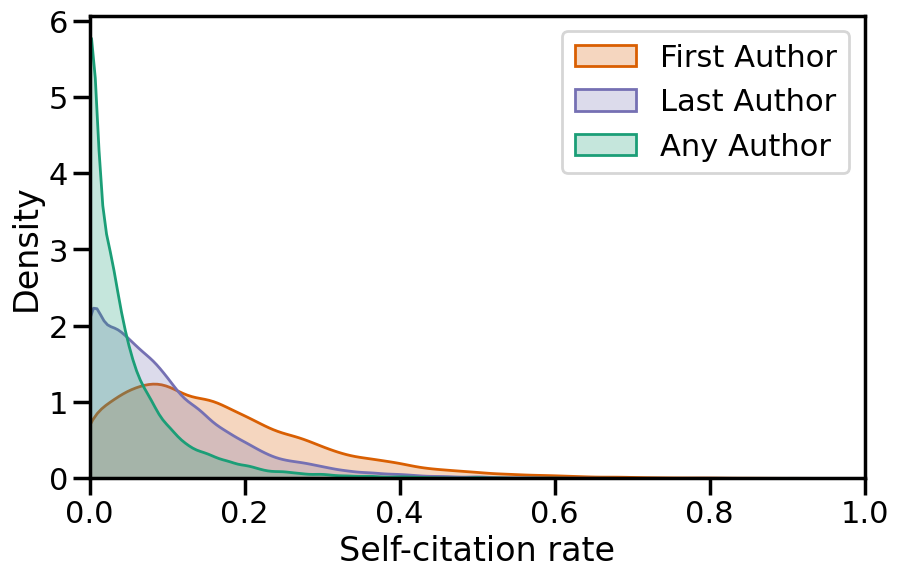

In [9]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10, 6)) 
sns.kdeplot(data=df[df.Year.isin([2016, 2017, 2018, 2019, 2020])], x='sc_rate', hue='SC Type', fill=True, ax=ax, palette=custom_palette[:3])
ax.set_xlim(0, 1)

ax.set_xlabel('Self-citation rate')
ax.legend(labels=['First Author', 'Last Author', 'Any Author'])

## over time

In [10]:
'''
print correlations and slopes for first author (first column),
last author (second column),
and any author (third column)
'''

# r values
print('****r values****')
print(np.mean(dat['r_boot'], axis=0))
print(np.percentile(dat['r_boot'], q=2.5, axis=0))
print(np.percentile(dat['r_boot'], q=97.5, axis=0))

# m values
print('****m values (%)****')
print(100*10*np.mean(dat['m_boot'], axis=0))  # 100*10 for percente per decade
print(100*10*np.percentile(dat['m_boot'], q=2.5, axis=0))
print(100*10*np.percentile(dat['m_boot'], q=97.5, axis=0))

****r values****
[-0.98223737 -0.39163848  0.5050628 ]
[-0.99033379 -0.62579688  0.10263349]
[-0.97167587 -0.12469216  0.72826513]
****m values (%)****
[-1.21063355 -0.17530962  0.32362104]
[-1.30226984 -0.3050877   0.05291984]
[-1.12451832 -0.05288527  0.54972144]


In [11]:
# print self-citation rates in 2000 and 2020

print('********Year 2000********')
print(np.mean(dat['sc_rates'][:, 0, :], axis=0))
print(np.percentile(dat['sc_rates'][:, 0, :], q=2.5, axis=0))
print(np.percentile(dat['sc_rates'][:, 0, :], q=97.5, axis=0))

print('********Year 2020********')
print(np.mean(dat['sc_rates'][:, -1, :], axis=0))
print(np.percentile(dat['sc_rates'][:, -1, :], q=2.5, axis=0))
print(np.percentile(dat['sc_rates'][:, -1, :], q=97.5, axis=0))


********Year 2000********
[0.06222882 0.08623243 0.14320296]
[0.05965761 0.08360369 0.13966431]
[0.06469632 0.08895517 0.14685719]
********Year 2020********
[0.03681783 0.07637263 0.13849057]
[0.03531083 0.07385059 0.13366968]
[0.03806466 0.07838933 0.14274027]


Text(0, 0.5, 'Self-citation rate')

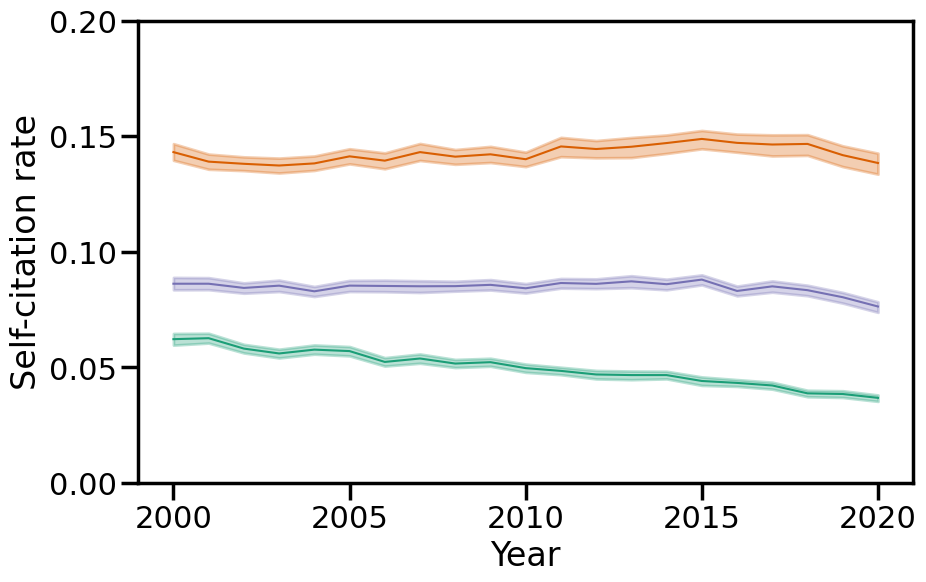

In [12]:
# Make plot of self-citation rate over time

sns.set_context('poster')
ordering = ['First Author', 'Last Author', 'Any Author']
years = np.arange(2000, 2021)
fig, ax = plt.subplots(figsize=(10, 6)) 
colors = custom_palette[:3]
sc_rates_time = dat['sc_rates']

for i, sc_type in enumerate(ordering):
    sc_time_iter = np.mean(sc_rates_time[:, :, i], axis=0)  # either first, last or any
    sc_lower = np.percentile(sc_rates_time[:, :, i], q=2.5, axis=0)
    sc_upper = np.percentile(sc_rates_time[:, :, i], q=97.5, axis=0)

    ax.plot(years, sc_time_iter, label=sc_type, color=custom_palette[i], linewidth=1.5)
    ax.fill_between(years, sc_lower, sc_upper, color=custom_palette[i], alpha=.3)

ax.set_xticks([2000, 2005, 2010, 2015, 2020])
ax.set_ylim([0, 0.2])
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax.set_xlabel('Year')
ax.set_ylabel('Self-citation rate')

Convert r to p values

In [13]:
# Convert correlations between self-citation rate and year to p values

import scipy
r1, r2, r3 = np.median(dat['r_boot'], axis=0)
N=21  # number of years
for r in [r1, r2, r3]:
    t = r  / np.sqrt((1-r**2)/(N-2))
    pval = 2*scipy.stats.t.sf(abs(t), N-2)
    print('r value: ' + str(r) + ' pvalue: ' + str(pval))

r value: -0.9828099437006099 pvalue: 2.103582681075334e-15
r value: -0.39742783114263547 pvalue: 0.0744167488910116
r value: 0.5352138752174589 pvalue: 0.012412954257072721


# Figure 2 - Academic Age

## for first or last auth

Text(0, 0.5, 'Self-citation rate')

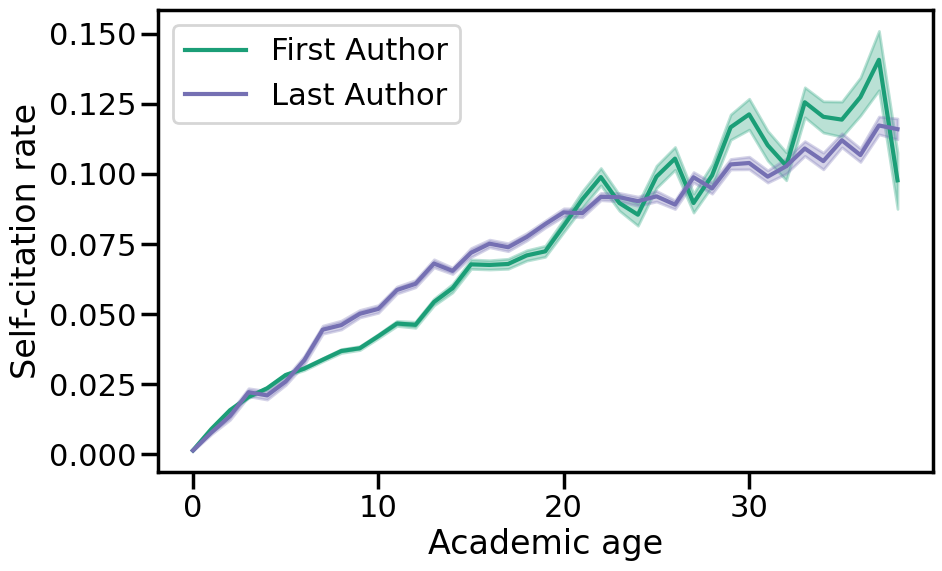

In [14]:
# Make plots of first/last author self-citation rates vs academic age

# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

# whether to plot as fraction of previous publication history or not
plot_type='standard'  # standard, normed
if plot_type=='normed':
    fa_ac_age_sc = dat['fa_ac_age_sc_normed']
    la_ac_age_sc = dat['la_ac_age_sc_normed']
    save_str = '_normed'
    y_ax_str = 'Normed self-citations'
else:
    fa_ac_age_sc = dat['fa_ac_age_sc']
    la_ac_age_sc = dat['la_ac_age_sc']
    save_str = ''
    y_ax_str = 'Self-citation rate'

# sum used to turn into one large list (dat contains list of lists)
fa_ac_age = np.sort(dat['ac_age_to_keep'])
nboot = np.shape(fa_ac_age_sc)[0]

la_ac_age = np.sort(dat['ac_age_to_keep'])




ac_age = np.tile(fa_ac_age, 2*nboot)
ac_age_sc = np.hstack((fa_ac_age_sc.ravel(), la_ac_age_sc.ravel()))

author_type = ['FA']*len(fa_ac_age_sc.ravel()) + ['LA']*len(la_ac_age_sc.ravel())

df_ac_age = pd.DataFrame(list(zip(ac_age, ac_age_sc, author_type)),
               columns =['ac_age', 'sc', 'author'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_ac_age, x='ac_age', y='sc', ci=None, hue='author', palette=custom_palette[:2])

# find 95% CI with 2.5, 97.5% quantile
df_quantiles=df_ac_age[df_ac_age.author=='FA'].groupby(['ac_age']).agg({'sc': [qlower, qupper]})
ax.fill_between(df_quantiles.index, df_quantiles['sc']['qlower'], df_quantiles['sc']['qupper'], color=custom_palette[0], alpha=.3)

df_quantiles=df_ac_age[df_ac_age.author=='LA'].groupby(['ac_age']).agg({'sc': [qlower, qupper]})
ax.fill_between(df_quantiles.index, df_quantiles['sc']['qlower'], df_quantiles['sc']['qupper'], color=custom_palette[1], alpha=.3)

# set labels and legends
ax.legend(labels=['First Author', 'Last Author'])
ax.set_xlabel('Academic age')
ax.set_ylabel(y_ax_str)



In [15]:
# print out actual numbers of self-citation rates at various academic ages
a = df_ac_age.groupby(['author', 'ac_age'], as_index=False).agg({'sc':'mean'})
a[a.ac_age.isin(np.arange(0, 31, 5))]

,author,ac_age,sc
0,FA,0,0.001257
5,FA,5,0.028193
10,FA,10,0.042061
15,FA,15,0.067701
20,FA,20,0.081465
25,FA,25,0.099020
30,FA,30,0.121255
39,LA,0,0.001250
44,LA,5,0.025860
49,LA,10,0.051800


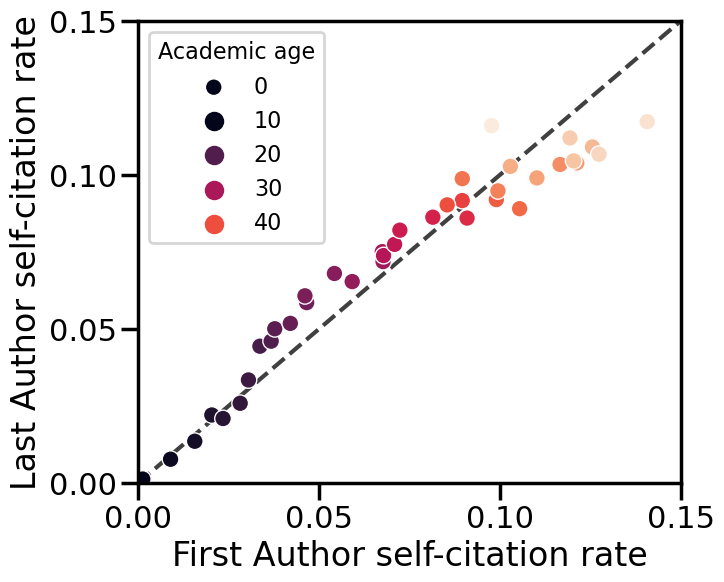

In [16]:
# Compare last author vs first author self-citation rates for each academic age

df_ac_age_fa = df_ac_age[df_ac_age['author']=='FA'].groupby('ac_age', as_index=False).agg({'sc':'mean'})
df_ac_age_la = df_ac_age[df_ac_age['author']=='LA'].groupby('ac_age', as_index=False).agg({'sc':'mean'})

df_ac_age_fa_vs_la = df_ac_age_fa.merge(df_ac_age_la, left_on='ac_age', right_on='ac_age')

fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(data=df_ac_age_fa_vs_la, x='sc_x', y='sc_y', ci=None, ax=ax, hue='ac_age', palette = "rocket")
ax.set_xlabel('First author')
ax.set_ylabel('Last author')
ax.set_xlim([0, 0.15])
ax.set_ylim([0, 0.15])
ax.set_xticks([0, 0.05, 0.1, 0.15])
ax.set_yticks([0, 0.05, 0.1, 0.15])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

# set legend
ax.set_xlabel('First Author self-citation rate')
ax.set_ylabel('Last Author self-citation rate')
ax.legend(title='Academic age', title_fontsize=16, labels=[0, 10, 20, 30, 40], fontsize=16)


# Figure 3 - Country

In [17]:
# load in from base dataframe
df_countries = df[(df.affil_country.isin(dat['fa_countries_to_keep'])) & (df['SC Type']=='FA')]  # keep first author data with countries
df_countries = df_countries.append(df[(df.affil_country.isin(dat['la_countries_to_keep'])) & (df['SC Type']=='LA')])  # add in last author data with countries
df_country_summary = df_countries.groupby(['SC Type', 'affil_country'],
                                          as_index=False).agg({'numref':'sum', 'sc_count':'sum', 'numpapers':'sum'})
df_country_summary['sum_perc'] = df_country_summary['sc_count'] / df_country_summary['numref']
df_country_summary = df_country_summary.sort_values(by=['affil_country'], ascending=True)  # sort to match existing list order


/home/mjr239/anaconda3/envs/sc/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/home/mjr239/anaconda3/envs/sc/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'First Author self-citation rates by country, min. 50 papers')

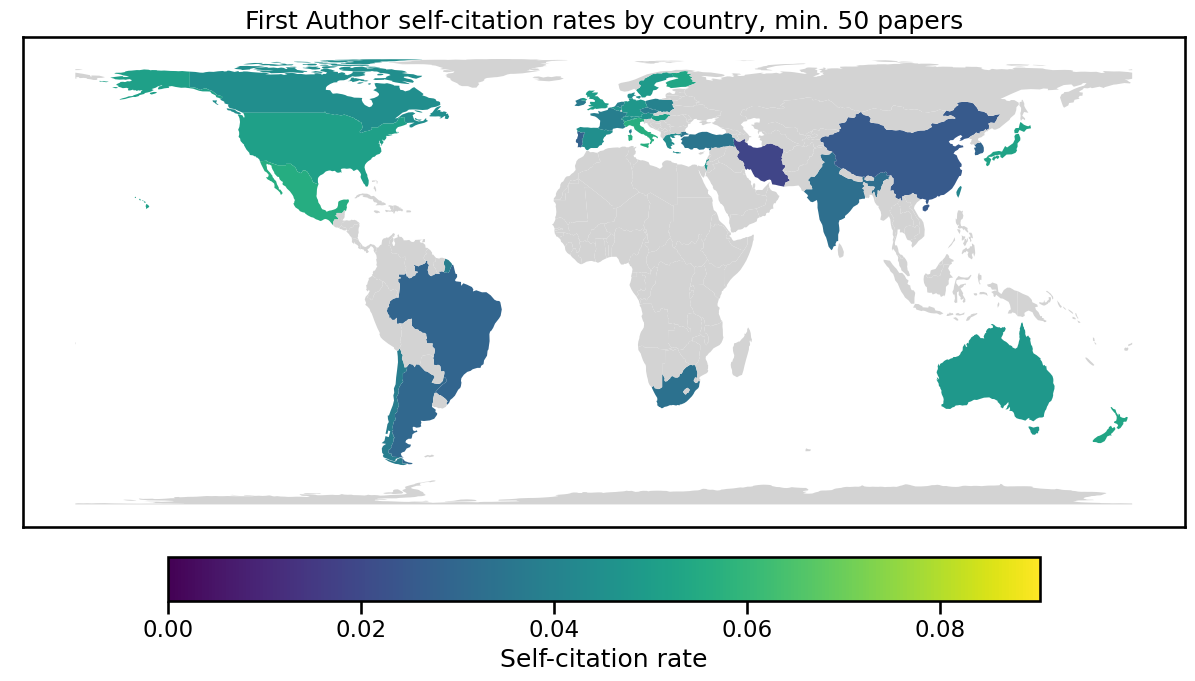

In [18]:
sns.set_context('talk')
# Plot map for first and/or last authors (change plot_type variable)
plot_type = 'FA'  # RUN FOR FA AND LA
paper_thresh = 50 # see boot code above
if plot_type=='FA':
    title_str = 'First Author'
elif plot_type=='LA':
    title_str = 'Last Author'
elif plot_type=='Any':
    title_str = 'Any Author'

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name=='France', 'iso_a3'] = 'FRA'  # fix france error where iso_a3 is excluded
df_plot = df_country_summary[df_country_summary['SC Type']==plot_type]
world = world.merge(df_plot, how='left', left_on=['iso_a3'], right_on=['affil_country'])
fig, ax = plt.subplots(figsize=(15, 8))
# cbar = plt.colorbar()
world = world.to_crs(epsg=6933)
world.plot(column='sum_perc', ax=ax, missing_kwds={'color': 'lightgrey'},
           legend=True,
           cmap='viridis', vmin=0, vmax=df_country_summary['sum_perc'].max(),
           legend_kwds={"label": "Self-citation rate",
                        "orientation": "horizontal", "pad":0.05,
                       "shrink":0.75})
ax.set_xticks([]); ax.set_yticks([])


ax.set_title(title_str + ' self-citation rates by country, min. ' + str(paper_thresh) + ' papers', fontsize=18)


Print out some summary stats

In [19]:
auth_type = 'la'
print('*************{:s}*************'.format(auth_type.upper()))
pd.DataFrame({'country': dat[auth_type+'_countries_to_keep'],
              'sc_median': np.median(dat[auth_type+'_sc_rate_country'], axis=0),
              'sc_lower': np.percentile(dat[auth_type+'_sc_rate_country'], q=2.5, axis=0),
              'sc_upper': np.percentile(dat[auth_type+'_sc_rate_country'], q=97.5, axis=0) })

*************LA*************


,country,sc_median,sc_lower,sc_upper
0,ARG,0.071128,0.057167,0.083546
1,AUS,0.075393,0.069588,0.079327
2,AUT,0.087282,0.072401,0.096249
3,BEL,0.075766,0.065770,0.082080
4,BRA,0.063678,0.055480,0.069842
5,CAN,0.078497,0.075496,0.081261
6,CHE,0.077229,0.073125,0.081804
7,CHL,0.083659,0.053684,0.095728
8,CHN,0.048435,0.045130,0.052048
9,CZE,0.048475,0.036725,0.061601


In [20]:
df_country_summary[df_country_summary['SC Type']=='LA'].sort_values(by='sum_perc')

,SC Type,affil_country,numref,sc_count,numpapers,sum_perc
72,LA,TUR,7441,206.0,187,0.027684
59,LA,IRN,3848,145.0,71,0.037682
75,LA,ZAF,4034,191.0,82,0.047348
47,LA,CZE,3811,183.0,77,0.048019
46,LA,CHN,43256,2092.0,818,0.048363
57,LA,IND,10550,519.0,241,0.049194
69,LA,PRT,14099,759.0,211,0.053834
63,LA,KOR,24355,1328.0,602,0.054527
54,LA,GRC,9915,585.0,186,0.059002
68,LA,POL,9086,573.0,184,0.063064


/home/mjr239/anaconda3/envs/sc/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/home/mjr239/anaconda3/envs/sc/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Normed self-citations for First Authors by country, min. 50 papers')

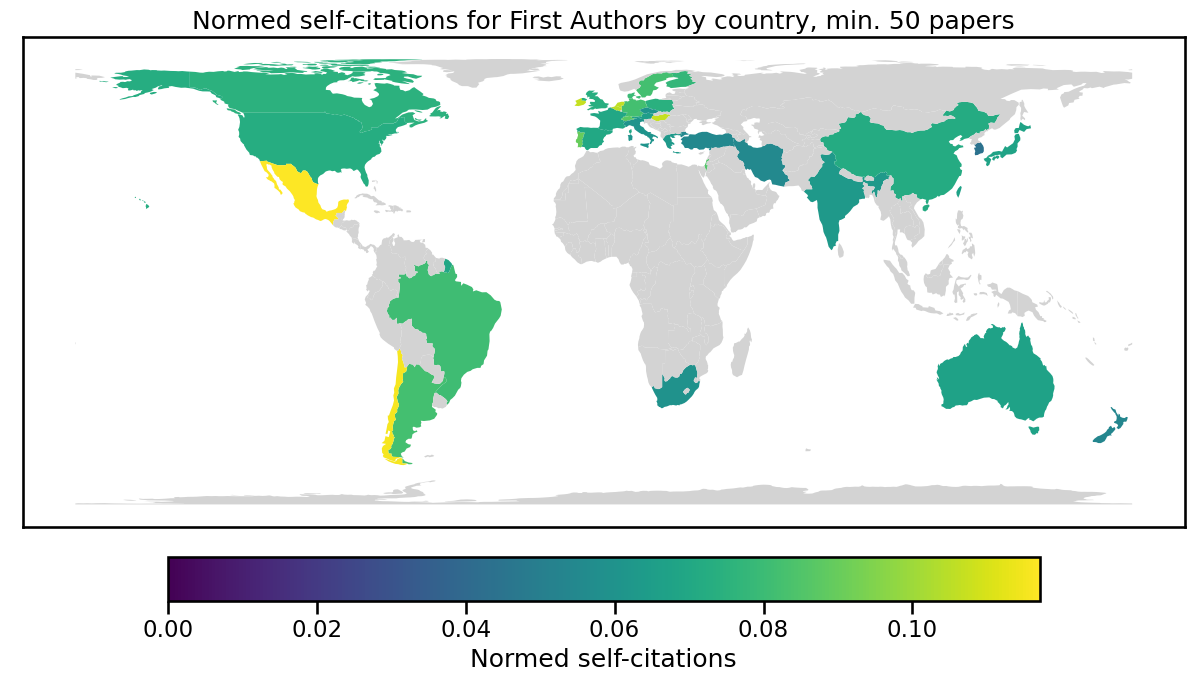

In [21]:
'''
Additional plots for country maps by 
1) Impact factor
2) Number of previous papers
'''
plot_type = 'FA'  # RUN FOR FA AND LA
plot_var = 'sc_normed'  # journal_citing_if, papers_before_by_date, sc_normed

# load in from base dataframe
df_countries = df[(df.affil_country.isin(dat['fa_countries_to_keep'])) & (df['SC Type']=='FA')]  # keep first author data with countries
df_countries = df_countries.append(df[(df.affil_country.isin(dat['la_countries_to_keep'])) & (df['SC Type']=='LA')])  # add in last author data with countries
df_country_summary = df_countries.groupby(['SC Type', 'affil_country'],
                                          as_index=False).agg({'numref':'sum', 'sc_count':'sum', 'numpapers':'sum',
                                                              'journal_citing_if':'mean', 'papers_before_by_date':'mean'})
df_country_summary['sum_perc'] = df_country_summary['sc_count'] / df_country_summary['numref']
df_country_summary['sc_normed'] = df_country_summary['sc_count'] / df_country_summary['papers_before_by_date'] / df_country_summary['numpapers']
df_country_summary = df_country_summary.sort_values(by=['affil_country'], ascending=True)  # sort to match existing list order

paper_thresh = 50 # see boot code above
if plot_type=='FA':
    title_auth_str = 'First Authors'
elif plot_type=='LA':
    title_auth_str = 'Last Authors'
    
if plot_var=='journal_citing_if':
    title_var_str = 'Mean impact factor'
elif plot_var=='papers_before_by_date':
    title_var_str = 'Mean # previous papers'
elif plot_var=='sc_normed':
    title_var_str = 'Normed self-citations'
    
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name=='France', 'iso_a3'] = 'FRA'  # fix france error where iso_a3 is excluded
df_plot = df_country_summary[df_country_summary['SC Type']==plot_type]
world = world.merge(df_plot, how='left', left_on=['iso_a3'], right_on=['affil_country'])
fig, ax = plt.subplots(figsize=(15, 8))
world = world.to_crs(epsg=6933)
world.plot(column=plot_var, ax=ax, missing_kwds={'color': 'lightgrey'},
           legend=True,
           cmap='viridis', vmin=0, vmax=df_country_summary[plot_var].max(),
           legend_kwds={"label": title_var_str,
                        "orientation": "horizontal", "pad":0.05,
                        "shrink":0.75})
ax.set_xticks([]); ax.set_yticks([])

ax.set_title('{:s} for {:s} by country, min. {:d} papers'.format(title_var_str, title_auth_str, paper_thresh), fontsize=18)


In [22]:
# Spearman correlation between self-citation rate, previous papers, and impact factor (averaged over country)
df_plot[['sum_perc', 'papers_before_by_date', 'journal_citing_if']].corr(method='spearman')

,sum_perc,papers_before_by_date,journal_citing_if
sum_perc,1.000000,0.576102,0.156801
papers_before_by_date,0.576102,1.000000,0.001422
journal_citing_if,0.156801,0.001422,1.000000


# Figure 4 - topics

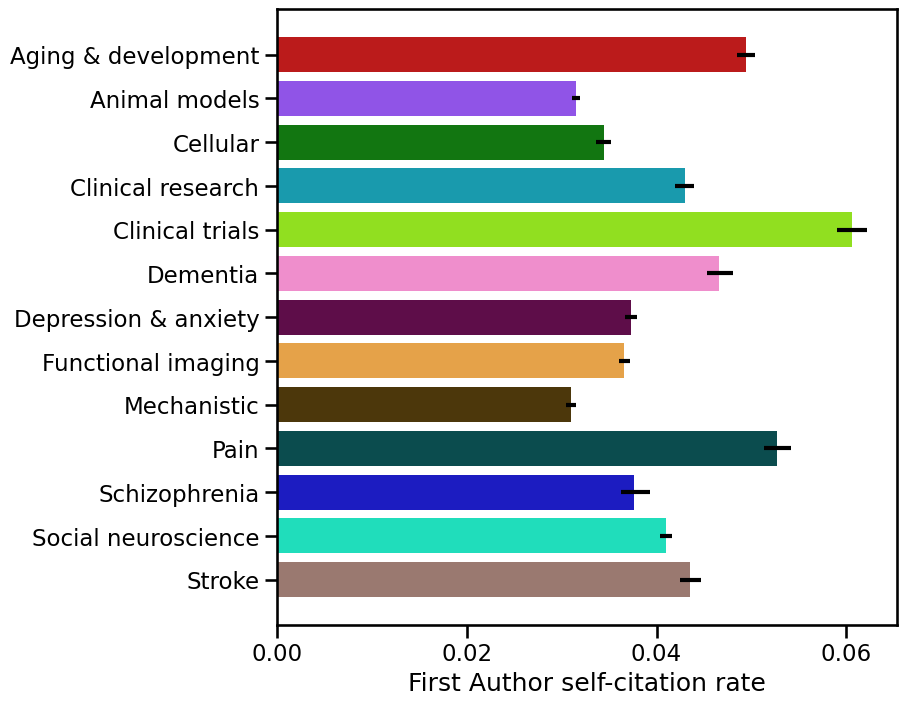

In [23]:
# plot self-citation rate by number of topics
author_type = 'FA'  # change to FA, LA, or Any
num_topics = 13

if author_type=='FA':
    title_str = 'First Author'
elif author_type=='LA':
    title_str = 'Last Author'
elif author_type=='Any':
    title_str = 'Any Author'


# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

topic_fa_sc=dat['topic_fa_sc']
topic_la_sc=dat['topic_la_sc']
topic_any_sc=dat['topic_any_sc']

topic_names = np.array(['Clinical research', 'Aging & development', 'Dementia', 'Functional imaging',
               'Pain', 'Animal models', 'Stroke', 'Clinical trials', 'Schizophrenia', 'Cellular', 
               'Mechanistic', 'Depression & anxiety', 'Social neuroscience'])
alphabetical_order = np.argsort(topic_names)
ntopics = len(topic_names)

topic_sc_array = np.array([])
auth_array = np.array([])
topic_id_array = np.array([])
num_boot_iters = np.shape(topic_fa_sc)[0]
for i in range(ntopics):
    topic_sc_array = np.concatenate([topic_sc_array, topic_fa_sc[:, i], topic_la_sc[:, i], topic_any_sc[:, i]])
    auth_array = np.concatenate([auth_array, num_boot_iters*['FA'], num_boot_iters*['LA'], num_boot_iters*['Any']])
    # topic_id_array = np.concatenate([topic_id_array, 3*num_boot_iters*[i]])
    topic_id_array = np.concatenate([topic_id_array, 3*num_boot_iters*[topic_names[i]]])

df_topics = pd.DataFrame({'topic':topic_id_array, 'auth':auth_array, 'sc':topic_sc_array})
df_topics = df_topics.sort_values('topic')

fig, ax = plt.subplots(figsize=(8, 8))
many_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
sns.barplot(data=df_topics[df_topics['auth']==author_type], y='topic', x='sc', ci=None, orient='h', ax=ax, palette=many_palette)

# get quantiles for CI, then add error bars
df_quantiles = df_topics[df_topics.auth==author_type].groupby(['topic']).agg({'sc': [qlower, qupper, 'median']})
df_mean = df_topics[df_topics.auth==author_type].groupby(['topic']).agg({'sc': 'mean'})
ci_vals = np.zeros((2, 13))
ci_vals[0, :] = np.abs(df_quantiles['sc']['qlower'] - df_mean['sc'])
ci_vals[1, :] = df_quantiles['sc']['qupper'] - df_mean['sc']
ax.errorbar(x=df_mean.sc, y=np.arange(0, 13), xerr=ci_vals, ls='', lw=3, color='black')

# axis labels
ax.set_ylabel('')
if author_type!='FA':  # remove tick labels for first author
    ax.set_yticks([])
ax.set_xlabel('{:s} self-citation rate'.format(title_str))

# 3 ticks
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

## topic and gender

In [24]:
import matplotlib.colors as mc
import colorsys
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """

    try:
        c = mc.cnames[color]
    except:
        c = color
        
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

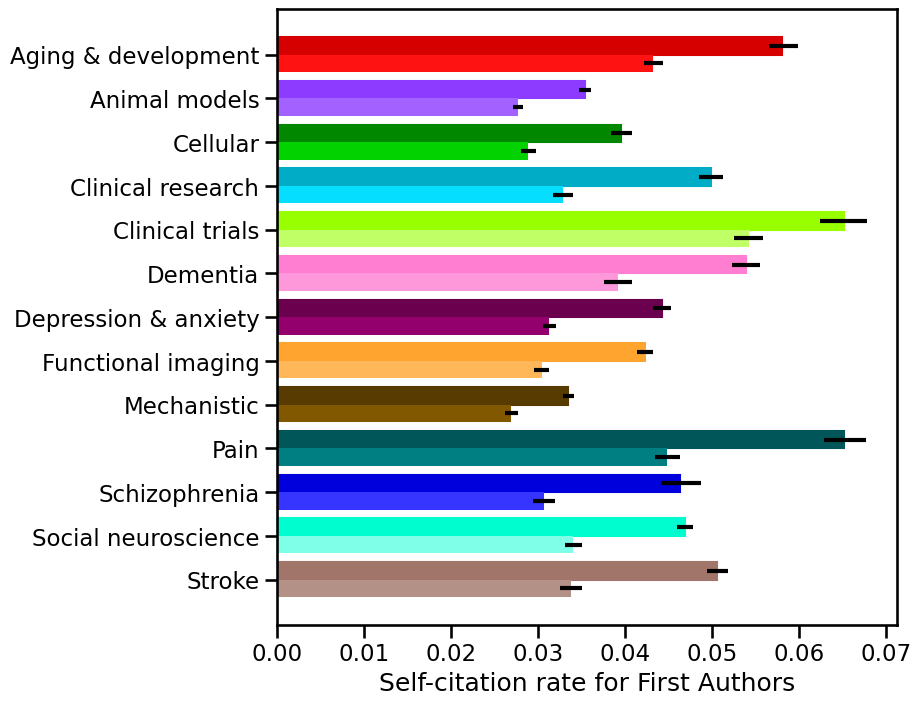

In [25]:
# Makes plot of gender proportions for each topic
plot_var = 'sc'  # gender_proportion, sc
author_type = 'FA'  # FA, LA, Any
auth_type_name_dict = {'FA': 'First Authors', 'LA':'Last Authors'}
num_topics = 13
from seaborn.utils import ci
import colorcet as cc

# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

# get proportion values
topic_fa_proportion_female=dat['perc_female_fa_la_topic'][:, :, 0]
topic_la_proportion_female=dat['perc_female_fa_la_topic'][:, :, 1]
topic_fa_proportion_male=1-topic_fa_proportion_female
topic_la_proportion_male=1-topic_la_proportion_female

# get self-citation values
topic_fa_sc_female=dat['topic_gender_sc_fa_female']
topic_la_sc_female=dat['topic_gender_sc_la_female']
topic_fa_sc_male=dat['topic_gender_sc_fa_male']
topic_la_sc_male=dat['topic_gender_sc_la_male']

# get and sort topic names (see Drive for order)
topic_names = np.array(['Clinical research', 'Aging & development', 'Dementia', 'Functional imaging',
               'Pain', 'Animal models', 'Stroke', 'Clinical trials', 'Schizophrenia', 'Cellular', 
               'Mechanistic', 'Depression & anxiety', 'Social neuroscience'])
alphabetical_order = np.argsort(topic_names)
ntopics = len(topic_names)

# initialize empty arrays
topic_proportion_array = np.array([])
topic_sc_array = np.array([])
auth_array = np.array([])
gender_array = np.array([])
topic_id_array = np.array([])

# loop over iterations
num_boot_iters = np.shape(topic_fa_sc)[0]
for i in range(ntopics):
    # get gender proportion
    topic_proportion_array = np.concatenate([topic_proportion_array, topic_fa_proportion_female[:, i], topic_fa_proportion_male[:, i],
                                   topic_la_proportion_female[:, i], topic_la_proportion_male[:, i]])

    # get gender sc rate
    topic_sc_array = np.concatenate([topic_sc_array, topic_fa_sc_female[:, i], topic_fa_sc_male[:, i],
                                   topic_la_sc_female[:, i], topic_la_sc_male[:, i]])
    
    # get additional information
    auth_array = np.concatenate([auth_array, num_boot_iters*['FA'], num_boot_iters*['FA'], num_boot_iters*['LA'], num_boot_iters*['LA']])
    gender_array = np.concatenate([gender_array, num_boot_iters*['Woman'], num_boot_iters*['Man'], num_boot_iters*['Woman'], num_boot_iters*['Man']])
    topic_id_array = np.concatenate([topic_id_array, 4*num_boot_iters*[topic_names[i]]])

# make into dataframe
df_topics = pd.DataFrame({'topic':topic_id_array, 'auth':auth_array, 'gender':gender_array, 
                          'gender_proportion':topic_proportion_array, 'sc':topic_sc_array})
df_topics = df_topics.sort_values('topic')

fig, ax = plt.subplots(figsize=(8, 8))
many_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
sns.barplot(data=df_topics[df_topics['auth']==author_type],
            y='topic', x=plot_var, hue='gender',
            ci=None, orient='h', ax=ax, palette=many_palette)

# make lighter palette for certain bars
lighter_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
lighten_amounts = [0.8, 0.8, 0.8, 0.8, 0.6, 0.8, 0.9, 0.8, 0.9, 0.9, 0.7, 0.5, 0.8]
for i in range(len(many_palette)):
    lighter_palette[i] = lighten_color(many_palette[i], amount=lighten_amounts[i])
for i, bar in enumerate(ax.patches):
    if i>=num_topics:
        palette_idx = i-num_topics
        bar.set_facecolor(lighter_palette[palette_idx])
        # bar.set_hatch('\\')
    else:
        palette_idx = i
        bar.set_color(many_palette[palette_idx])


df_quantiles = df_topics[df_topics.auth==author_type].groupby(['topic', 'gender'],
                                                              as_index=False).agg({plot_var: [qlower, qupper]})
df_mean = df_topics[df_topics.auth==author_type].groupby(['topic', 'gender'],
                                                         as_index=False).agg({plot_var: 'mean'})
ci_vals = np.zeros((2, 2*num_topics))
ci_vals[0, :] = np.abs(df_quantiles[plot_var]['qlower'] - df_mean[plot_var])
ci_vals[1, :] = df_quantiles[plot_var]['qupper'] - df_mean[plot_var]

# add two legends
# h,l = ax.get_legend_handles_labels() ##Get the legend handles and lables
# l1 = ax.legend(h[:int(len(h)/2)],l[:int(len(l)/2)], loc='upper left',bbox_to_anchor=(1.01,1)) ##Plot half as the first legend

# from matplotlib.container import BarContainer
# myHandle = [BarContainer(color='red'),  BarContainer(color='green')] ##Create custom handles for 2nd legend
# l2 = ax.legend(handles=myHandle, labels = ['Neuroscience', 'Nature Neuroscience'],
#                loc='upper left', bbox_to_anchor=(1.01, 0.6),) ##Add 2nd legend


# make array with locations of errorbars
y1 = np.arange(-.2, num_topics-.2, 1)
y2 = np.arange(0.2, num_topics-.2, 1)
y = np.zeros((len(y1) + len(y2)), )
y[::2] = y1; y[1::2] = y2
ax.errorbar(x=df_mean[plot_var], y=y,
            xerr=ci_vals, ls='', lw=3, color='black')

# update legend colors
if author_type=='LA':
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('#636363')
    leg.legendHandles[1].set_color('#bdbdbd')
    leg.set_title('')
    leg.set_bbox_to_anchor((1.01, 1))
    
    ax.set_yticklabels([])
else:
    ax.get_legend().remove()

# set labels
ax.set_ylabel('')
if plot_var=='gender_proportion':
    ax.set_xlabel('Proportion of {:s}'.format(auth_type_name_dict[author_type]))
else:
    ax.set_xlabel('Self-citation rate for {:s}'.format(auth_type_name_dict[author_type]))


# Figure 5 - gender

In [26]:
# Print bootstrap results: compare sc rates for men/women
print('Men FA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_fa_male'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_male'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_male'][:, -1], q=97.5)) + ')')
print('Women FA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_fa_female'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_female'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_female'][:, -1], q=97.5)) + ')')
# print(calc_pval(dat['time_gender_sc_fa_male'][:, -1], dat['time_gender_sc_fa_female'][:, -1]))


print('Men LA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_la_male'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_male'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_male'][:, -1], q=97.5)) + ')')
print('Women LA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_la_female'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_female'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_female'][:, -1], q=97.5)) + ')')
# print(calc_pval(dat['time_gender_sc_la_male'][:, -1], dat['time_gender_sc_la_female'][:, -1]))


Men FA sc in 2020: 0.041155 (0.039094, 0.042874)
Women FA sc in 2020: 0.032360 (0.030574, 0.034080)
Men LA sc in 2020: 0.079313 (0.076419, 0.081629)
Women LA sc in 2020: 0.070896 (0.067805, 0.073610)


## time author proportion

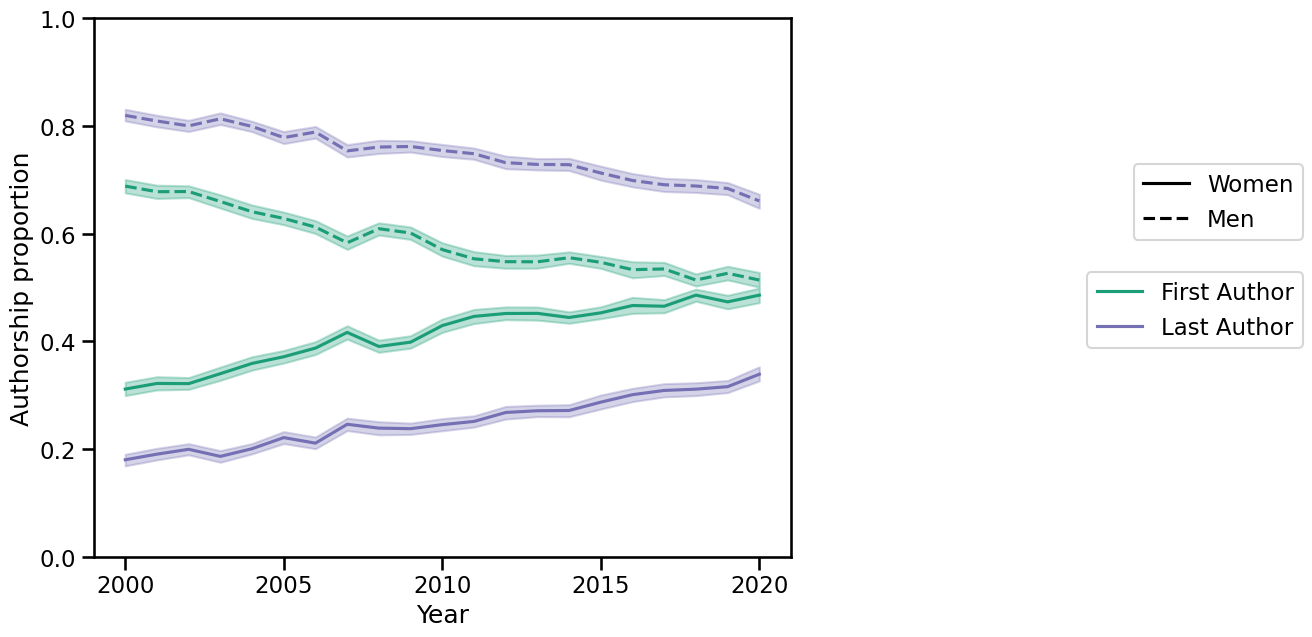

In [27]:
# Plot proportion of men/womenauthors over time
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

fa_gender_ratio = dat['time_gender_sc_fa_male'] / dat['time_gender_sc_fa_female']
fa_lower = np.percentile(dat['time_gender_proportion_fa_female'], q=2.5, axis=0)
fa_upper = np.percentile(fa_gender_ratio, q=97.5, axis=0)

la_gender_ratio = dat['time_gender_sc_la_male'] / dat['time_gender_sc_la_female']
la_lower = np.percentile(la_gender_ratio, q=2.5, axis=0)
la_upper = np.percentile(la_gender_ratio, q=97.5, axis=0)

years = np.arange(2000, 2021)

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(years, np.mean(dat['time_gender_proportion_fa_female'], axis=0), color=custom_palette[0], label='Woman FA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_fa_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_fa_female'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for first author man
ax.plot(years, np.mean(dat['time_gender_proportion_fa_male'], axis=0), color=custom_palette[0], label='Man FA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_fa_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_fa_male'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for last author woman
ax.plot(years, np.mean(dat['time_gender_proportion_la_female'], axis=0), color=custom_palette[1], label='Woman LA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_la_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_la_female'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

# for last author man
ax.plot(years, np.mean(dat['time_gender_proportion_la_male'], axis=0), color=custom_palette[1], label='Man LA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_la_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_la_male'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

plt.xlabel('Year')
plt.ylabel('Authorship proportion')
ax.set_ylim([0, 1])
ax.set_xticks([2000, 2005, 2010, 2015, 2020])

# modify legends / custom legends: see https://matplotlib.org/stable/users/explain/axes/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
fa_line = matplotlib.lines.Line2D([], [], color=custom_palette[0], label='First Author')
la_line = matplotlib.lines.Line2D([], [], color=custom_palette[1], label='Last Author')
leg1 = ax.legend(handles=[fa_line, la_line], bbox_to_anchor=(1.75, .55))
ax.add_artist(leg1)
w_line = matplotlib.lines.Line2D([], [], color='black', linestyle='-', label='Women')
m_line = matplotlib.lines.Line2D([], [], color='black', linestyle='--', label='Men')
ax.legend(handles=[w_line, m_line], bbox_to_anchor=(1.75, .75))


In [28]:
print(dat['time_gender_proportion_fa_female'].mean(axis=0))

[0.31173326 0.32214619 0.32180512 0.34028312 0.35931873 0.3717181
 0.38774001 0.41685436 0.39077183 0.39874448 0.4295231  0.44655353
 0.45194469 0.45217891 0.44453246 0.45314575 0.46675971 0.46541068
 0.48601991 0.47350237 0.4860176 ]


In [29]:
# assess convergence of authorship proportions with CIs
nboot = np.shape(dat['time_gender_proportion_fa_female'])[0]
projection_fa = np.zeros((nboot,))
projection_la = np.zeros((nboot,))
year_range = np.arange(21)
# loop over all bootstrap iterations
for i in range(nboot):
    # regression lines for men and women first authors
    regr_fa_female = linregress(year_range, dat['time_gender_proportion_fa_female'][i, :])
    regr_fa_male = linregress(year_range, dat['time_gender_proportion_fa_male'][i, :])
    # find interesection point
    projection_fa[i] = (regr_fa_male.intercept - regr_fa_female.intercept) / (regr_fa_female.slope - regr_fa_male.slope)

    # regression lines for men and women last authors
    regr_la_female = linregress(year_range, dat['time_gender_proportion_la_female'][i, :])
    regr_la_male = linregress(year_range, dat['time_gender_proportion_la_male'][i, :])
    # find intersection point
    projection_la[i] = (regr_la_male.intercept - regr_la_female.intercept) / (regr_la_female.slope - regr_la_male.slope)

print('For first authors: ' + '{:.2f}'.format(np.mean(projection_fa)) + ' (' + '{:.2f}'.format(np.percentile(projection_fa, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_fa, q=97.5)) + ')')
print('For last authors: ' + '{:.2f}'.format(np.mean(projection_la)) + ' (' + '{:.2f}'.format(np.percentile(projection_la, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_la, q=97.5)) + ')')

For first authors: 19.77 (18.85, 20.79)
For last authors: 43.10 (40.13, 46.20)


## ratio of self-citation rates of men to women over time

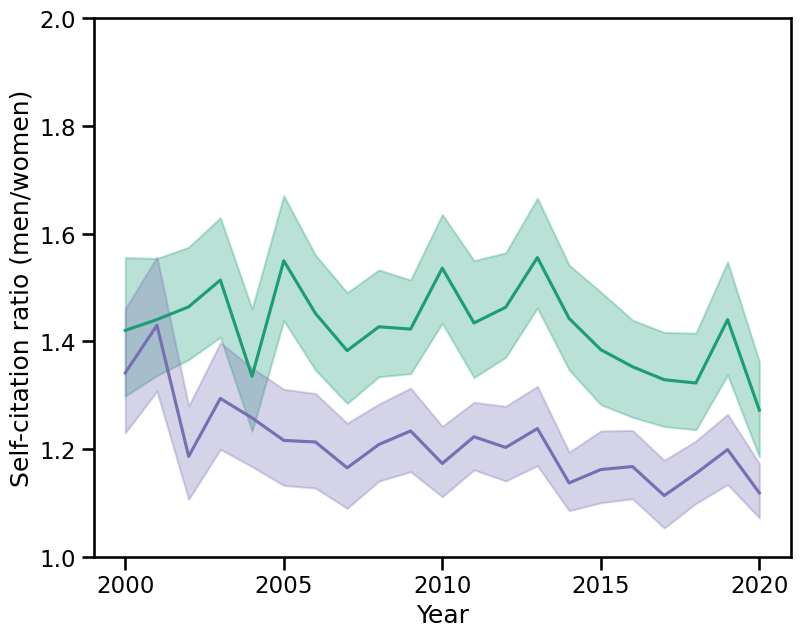

In [31]:
# plot ratio of self-citation rates by gender over time
fa_gender_ratio = dat['time_gender_sc_fa_male'] / dat['time_gender_sc_fa_female']
fa_lower = np.percentile(fa_gender_ratio, q=2.5, axis=0)
fa_upper = np.percentile(fa_gender_ratio, q=97.5, axis=0)

la_gender_ratio = dat['time_gender_sc_la_male'] / dat['time_gender_sc_la_female']
la_lower = np.percentile(la_gender_ratio, q=2.5, axis=0)
la_upper = np.percentile(la_gender_ratio, q=97.5, axis=0)

years = np.arange(2000, 2021)

fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(years, np.mean(fa_gender_ratio, axis=0), color=custom_palette[0], label='First author')
ax.fill_between(years, fa_lower, fa_upper, color=custom_palette[0], alpha=.3)


ax.plot(years, np.mean(la_gender_ratio, axis=0), color=custom_palette[1], label='Last author')
ax.fill_between(years, la_lower, la_upper, color=custom_palette[1], alpha=.3)

# plt.legend()
plt.xlabel('Year')
plt.ylabel('Self-citation ratio (men/women)')
ax.set_ylim([1, 2])
ax.set_xticks([2000, 2005, 2010, 2015, 2020])

In [40]:
# show range of gender self-citation rate ratios for first aurhotrs
mean_fa_ratios_by_year = np.mean(fa_gender_ratio, axis=0)
print('Lowest gender sc ratio for first authors: {:.4f} and highest {:.4f}'.format(np.min(mean_fa_ratios_by_year), np.max(mean_fa_ratios_by_year)))


# for last authors
mean_la_ratios_by_year = np.mean(la_gender_ratio, axis=0)
print('Lowest gender sc ratio for last authors: {:.4f} and highest {:.4f}'.format(np.min(mean_la_ratios_by_year), np.max(mean_la_ratios_by_year)))

mean_la_ratios_by_year = np.mean(la_gender_ratio, axis=0)[2:]
print('Excluding first 2 years, lowest gender sc ratio for last authors: {:.4f} and highest {:.4f}'.format(np.min(mean_la_ratios_by_year), np.max(mean_la_ratios_by_year)))

Lowest gender sc ratio for first authors: 1.2727 and highest 1.5557
Lowest gender sc ratio for last authors: 1.1141 and highest 1.4300
Excluding first 2 years, lowest gender sc ratio for last authors: 1.1141 and highest 1.2943


## time gender sc

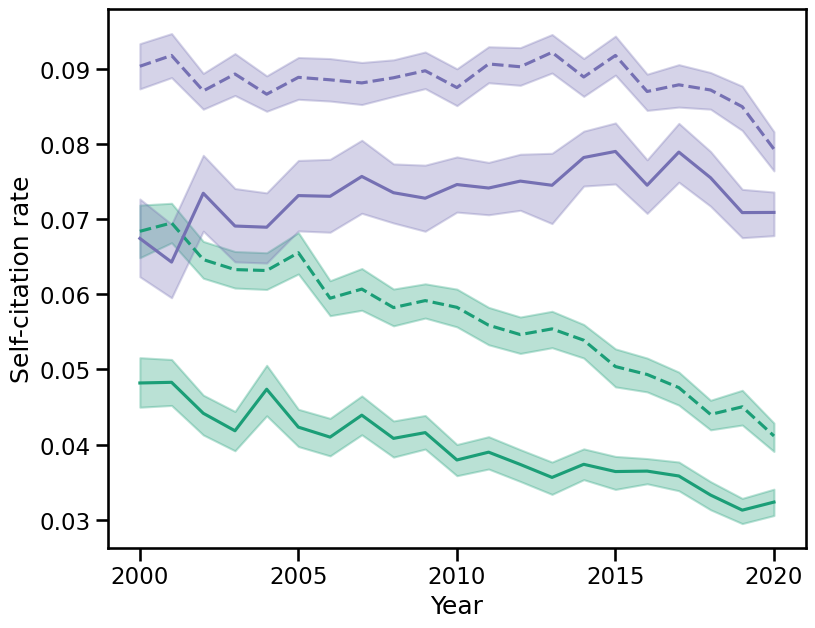

In [41]:
# plot gender self-citation rates over time
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

years = np.arange(2000, 2021)

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(years, np.mean(dat['time_gender_sc_fa_female'], axis=0), color=custom_palette[0], label='Woman FA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_sc_fa_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_fa_female'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for first author man
ax.plot(years, np.mean(dat['time_gender_sc_fa_male'], axis=0), color=custom_palette[0], label='Man FA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_sc_fa_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_fa_male'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for last author woman
ax.plot(years, np.mean(dat['time_gender_sc_la_female'], axis=0), color=custom_palette[1], label='Woman LA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_sc_la_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_la_female'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

# for last author man
ax.plot(years, np.mean(dat['time_gender_sc_la_male'], axis=0), color=custom_palette[1], label='Man LA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_sc_la_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_la_male'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

# plt.legend()
plt.xlabel('Year')
plt.ylabel('Self-citation rate')
ax.set_xticks([2000, 2005, 2010, 2015, 2020])

# ax.set_ylim([0, 1])


In [42]:
# assess convergence of self-citation rates with CIs
nboot = np.shape(dat['time_gender_sc_fa_male'])[0]
projection_fa = np.zeros((nboot,))
projection_la = np.zeros((nboot,))
year_range = np.arange(21)

for i in range(nboot):
    regr_fa_female = linregress(year_range, dat['time_gender_sc_fa_female'][i, :])
    regr_fa_male = linregress(year_range, dat['time_gender_sc_fa_male'][i, :])
    projection_fa[i] = (regr_fa_male.intercept - regr_fa_female.intercept) / (regr_fa_female.slope - regr_fa_male.slope)

    regr_la_female = linregress(year_range, dat['time_gender_sc_la_female'][i, :])
    regr_la_male = linregress(year_range, dat['time_gender_sc_la_male'][i, :])
    projection_la[i] = (regr_la_male.intercept - regr_la_female.intercept) / (regr_la_female.slope - regr_la_male.slope)

print('For first authors: ' + '{:.2f}'.format(np.mean(projection_fa)) + ' (' + '{:.2f}'.format(np.percentile(projection_fa, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_fa, q=97.5)) + ')')
print('For last authors: ' + '{:.2f}'.format(np.mean(projection_la)) + ' (' + '{:.2f}'.format(np.percentile(projection_la, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_la, q=97.5)) + ')')

For first authors: 44.12 (35.74, 55.55)
For last authors: 40.19 (30.32, 60.51)


## gender ac age

Text(0, 0.5, 'Self-citation rate')

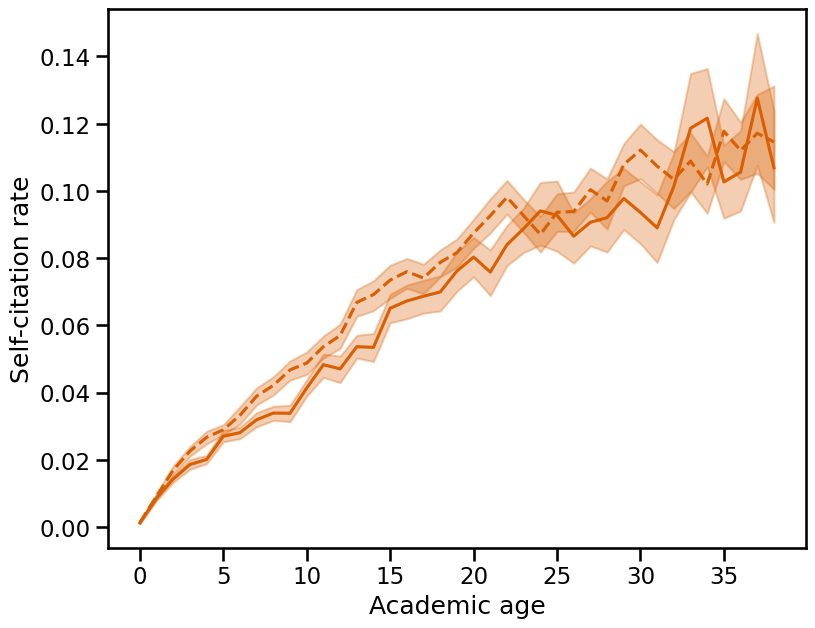

In [43]:
# make plots of self-citation rate vs academic age grouped by gender
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['ac_age_gender_sc_male'])[1])

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(ac_ages, np.mean(dat['ac_age_gender_sc_female'], axis=0), color=custom_palette[2], label='Woman', linestyle=gender_style[0])
ax.fill_between(ac_ages, np.percentile(dat['ac_age_gender_sc_female'], q=2.5, axis=0),
                np.percentile(dat['ac_age_gender_sc_female'], q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

# for first author man
ax.plot(ac_ages, np.mean(dat['ac_age_gender_sc_male'], axis=0), color=custom_palette[2], label='Man', linestyle=gender_style[1])
ax.fill_between(ac_ages, np.percentile(dat['ac_age_gender_sc_male'], q=2.5, axis=0),
                np.percentile(dat['ac_age_gender_sc_male'], q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

# plt.legend()
plt.xlabel('Academic age')
plt.ylabel('Self-citation rate')
# ax.set_ylim([0, 1])


## gender ac age ratio

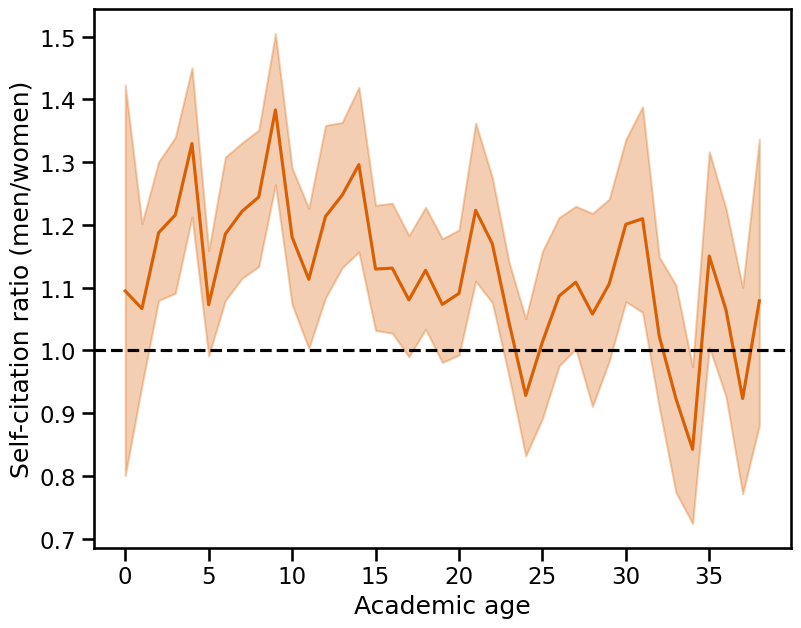

In [44]:
# ratio of self-citation rates of men to women for each academic age
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['ac_age_gender_sc_male'])[1])
sc_ratio_ac_age = dat['ac_age_gender_sc_male'] / dat['ac_age_gender_sc_female']

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(ac_ages, np.mean(sc_ratio_ac_age, axis=0), color=custom_palette[2])
ax.fill_between(ac_ages, np.percentile(sc_ratio_ac_age, q=2.5, axis=0),
                np.percentile(sc_ratio_ac_age, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)


plt.xlabel('Academic age')
plt.ylabel('Self-citation ratio (men/women)')
ax.axhline(y=1, color='black', linestyle='--')
# ax.set_ylim([0, 1])


In [45]:
# print out mean ratios by academic age (after running above)
np.mean(sc_ratio_ac_age, axis=0)

array([1.09470097, 1.06658911, 1.18758002, 1.21584349, 1.32972273,
       1.07271794, 1.1855529 , 1.22174614, 1.24444585, 1.38329295,
       1.18041373, 1.11329365, 1.21346322, 1.24738565, 1.2960326 ,
       1.12969642, 1.13106924, 1.08046481, 1.12769591, 1.07332338,
       1.09077024, 1.22326679, 1.16972916, 1.04461572, 0.92821139,
       1.01343912, 1.08666856, 1.10869051, 1.05785032, 1.10586653,
       1.20101471, 1.20989977, 1.02297415, 0.92333094, 0.84229559,
       1.1503334 , 1.06467599, 0.92322876, 1.07900378])

In [46]:
# this code makes df of gender sc rates by academic age
df_tmp = df[ (df.gender_binary!='Error') & (df.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df.ac_age.isin(dat['ac_age_to_keep']))]
df_ac_age_gender_summary = df_tmp.groupby(['ac_age', 'gender_binary'], as_index=False).agg({'numpapers':'sum', 'numref':'sum', 'sc_count':'sum'})
df_ac_age_gender_summary['sc_rate'] = df_ac_age_gender_summary['sc_count'] / df_ac_age_gender_summary['numref']
df_ac_age_gender_summary.head(25)

,ac_age,gender_binary,numpapers,numref,sc_count,sc_rate
0,0.0,Female,1291,74364,90.0,0.001210
1,0.0,Male,964,55794,73.0,0.001308
2,1.0,Female,749,45600,391.0,0.008575
3,1.0,Male,647,40238,367.0,0.009121
4,2.0,Female,940,54384,774.0,0.014232
5,2.0,Male,819,46998,795.0,0.016916
6,3.0,Female,1017,59612,1107.0,0.018570
7,3.0,Male,949,55071,1242.0,0.022553
8,4.0,Female,1035,61675,1239.0,0.020089
9,4.0,Male,982,56780,1513.0,0.026647


In [47]:
# this code looks at gender sc differences in first 10 years
df_tmp = df[ (df.gender_binary!='Error') & (df.Year.isin([2016, 2017, 2018, 2019, 2020])) & 
            (df.ac_age.isin([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))]
df_ac_age_gender_summary = df_tmp.groupby(['gender_binary'], as_index=False).agg({'numpapers':'sum', 'numref':'sum', 'sc_count':'sum'})
df_ac_age_gender_summary['sc_rate'] = df_ac_age_gender_summary['sc_count'] / df_ac_age_gender_summary['numref']
print('In first 10 years, men sc rate: {:.4f}, women sc rate: {:.4f}, ratio: {:.4f}'.format(float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Male']['sc_rate']),
                                                                                            float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Female']['sc_rate']),
                                                                                            float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Male']['sc_rate'])/float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Female']['sc_rate'])))
df_ac_age_gender_summary

In first 10 years, men sc rate: 0.0298, women sc rate: 0.0224, ratio: 1.3313


,gender_binary,numpapers,numref,sc_count,sc_rate
0,Female,10155,600262,13426.0,0.022367
1,Male,10694,617881,18399.0,0.029778


## bar plot sc by numpapers groups

Text(0.5, 0, 'Number of previous papers (groups)')

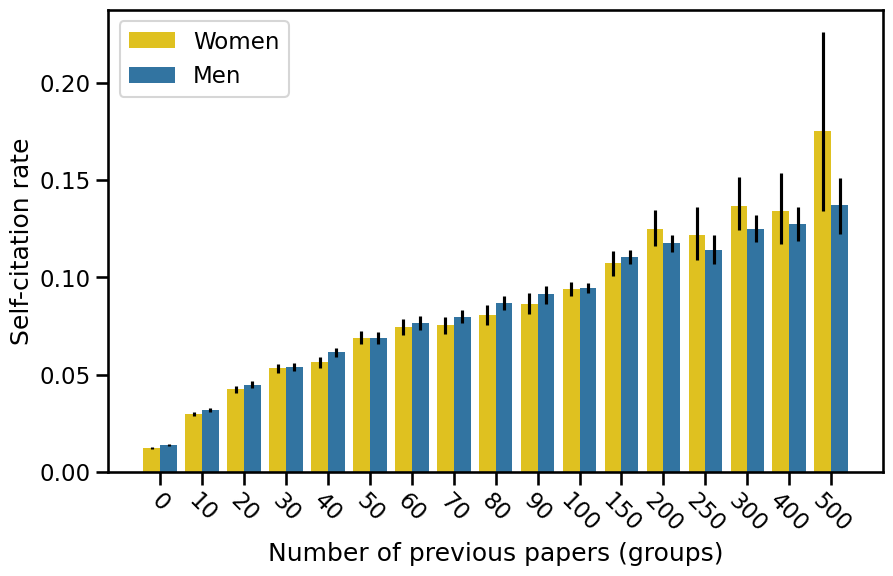

In [48]:
# Bin by number of previous papers and plot self-citation rates by gender
num_papers_groups = dat['num_papers_groups']
ngroups = len(num_papers_groups)
num_papers_sc_groups_male = dat['num_papers_sc_groups_male']
num_papers_sc_groups_female = dat['num_papers_sc_groups_female']

num_papers_sc_groups_male_lower = np.percentile(num_papers_sc_groups_male, q=2.5, axis=0)
num_papers_sc_groups_male_upper = np.percentile(num_papers_sc_groups_male, q=97.5, axis=0)

num_papers_sc_groups_female_lower = np.percentile(num_papers_sc_groups_female, q=2.5, axis=0)
num_papers_sc_groups_female_upper = np.percentile(num_papers_sc_groups_female, q=97.5, axis=0)


gender_binary = ['Women']*len(num_papers_groups)
gender_binary.extend(['Men']*len(num_papers_groups))

df_plot = pd.DataFrame({'gender_binary':gender_binary, 'num_papers_group':np.tile(num_papers_groups, 2), 'sc_rate':np.hstack( (np.mean(num_papers_sc_groups_female, axis=0), np.mean(num_papers_sc_groups_male, axis=0)) )})

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_plot, x='num_papers_group', y='sc_rate', ci=None, hue='gender_binary', ax=ax, palette=['#ffd700', (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)])


for i, p in enumerate(ax.patches):
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    
    if i<ngroups:
        min_y = num_papers_sc_groups_female_lower[ i ]
        max_y = num_papers_sc_groups_female_upper[ i ]
    else:
        min_y = num_papers_sc_groups_male_lower[ i - ngroups]
        max_y = num_papers_sc_groups_male_upper[ i - ngroups]

    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line
  
plt.xticks(rotation=-45)
plt.legend(title='', loc='upper left')
plt.ylabel('Self-citation rate')
plt.xlabel('Number of previous papers (groups)')


Look at number of papers by ac age

Text(0, 0.5, 'Number of papers')

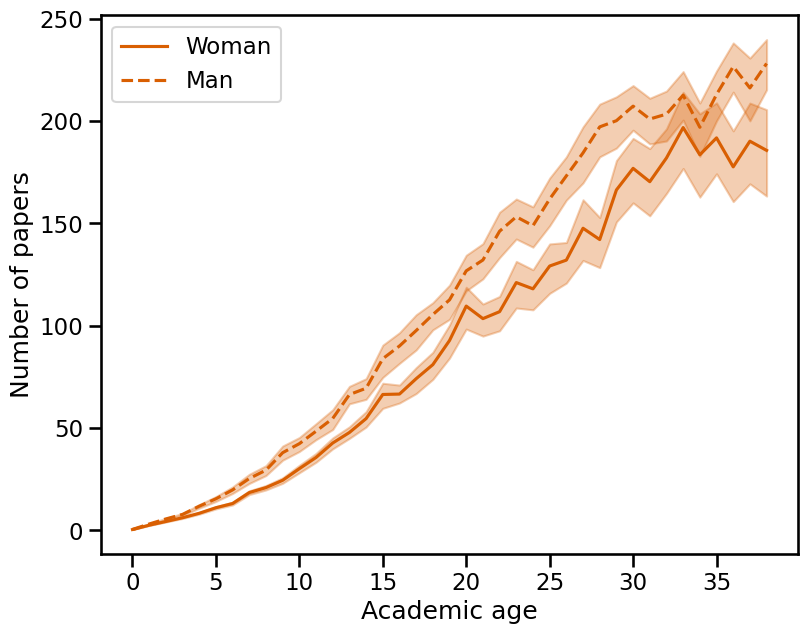

In [49]:
# Plot number of papers by academic age, grouped by gender
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['num_papers_by_ac_age_male'])[1])

ac_age_gender_numpapers_female = dat['num_papers_by_ac_age_female'][:, :, 1]  # 0 is ac age

ac_age_gender_numpapers_male = dat['num_papers_by_ac_age_male'][:, :, 1]  # 0 is ac age


fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(ac_ages, np.mean(ac_age_gender_numpapers_female, axis=0), color=custom_palette[2], label='Woman', linestyle=gender_style[0])
ax.fill_between(ac_ages, np.percentile(ac_age_gender_numpapers_female, q=2.5, axis=0),
                np.percentile(ac_age_gender_numpapers_female, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

# for first author man
ax.plot(ac_ages, np.mean(ac_age_gender_numpapers_male, axis=0), color=custom_palette[2], label='Man', linestyle=gender_style[1])
ax.fill_between(ac_ages, np.percentile(ac_age_gender_numpapers_male, q=2.5, axis=0),
                np.percentile(ac_age_gender_numpapers_male, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

plt.legend()
plt.xlabel('Academic age')
plt.ylabel('Number of papers')
# ax.set_ylim([0, 1])


In [50]:
print(ac_age_gender_numpapers_male.mean(axis=0)[10])
print(np.std(ac_age_gender_numpapers_male,axis=0)[10])

42.31521052469806
1.764531912276183


(0.5, 2.5)

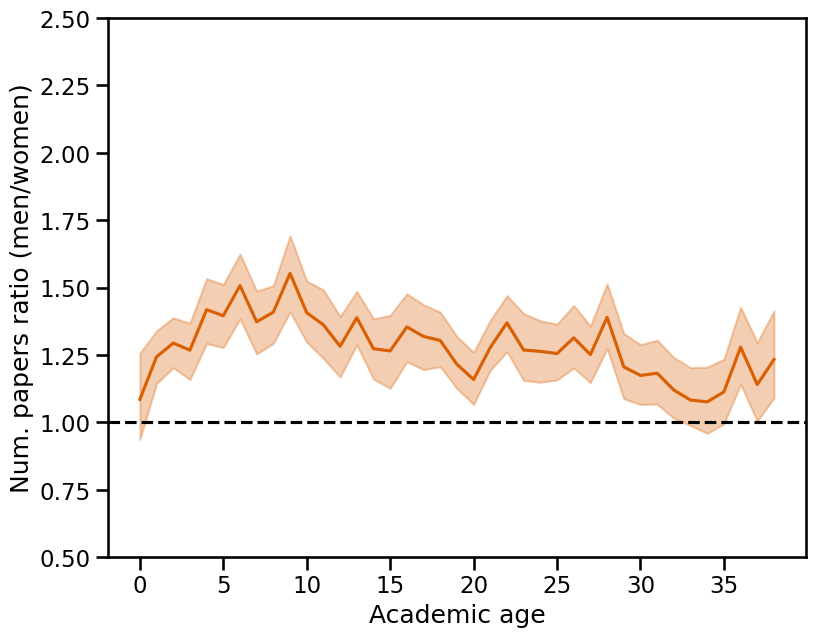

In [51]:
# Plot number of papers by academic age, ratio of men to women
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['num_papers_by_ac_age_male'])[1])

ac_age_gender_numpapers_female = dat['num_papers_by_ac_age_female'][:, :, 1]  # 0 is ac age

ac_age_gender_numpapers_male = dat['num_papers_by_ac_age_male'][:, :, 1]  # 0 is ac age
paper_ratio_ac_age = ac_age_gender_numpapers_male / ac_age_gender_numpapers_female


fig, ax = plt.subplots(figsize=(9, 7))

# for ratio of papers by academic age
ax.plot(ac_ages, np.mean(paper_ratio_ac_age, axis=0), color=custom_palette[2])
ax.fill_between(ac_ages, np.percentile(paper_ratio_ac_age, q=2.5, axis=0),
                np.percentile(paper_ratio_ac_age, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)


ax.axhline(y=1, color='black', linestyle='--')
plt.xlabel('Academic age')
plt.ylabel('Num. papers ratio (men/women)')
ax.set_ylim([0.5, 2.5])


# Null models / permutation testing

In [32]:
def calc_p_from_null(null_dist, thresh, n_perm=10000):
  # two-sided
  return np.mean(np.abs(null_dist)>np.abs(thresh)) + 1/n_perm

In [33]:
null_path = './null/'
npermutations = 10000


## For comparing neurosci to neurology

In [54]:
npermutations = 10000
null_diff_fa = np.zeros((npermutations, ))
null_diff_la = np.zeros((npermutations, ))
null_diff_any = np.zeros((npermutations, ))

for seed in tqdm(range(npermutations)):
    np.random.seed(seed)

    # Null distribution for neuroscience vs psychiatry
    df_null = df[(df.Year.isin([2016, 2017, 2018, 2019, 2020])) & 
                 (df['field'].isin(['Neuroscience', 'Neurology']))]
    
    
    # get exchangeability groups
    eb_unique = df_null['eb'].unique()

    # group counts for comparison of interest
    group_counts = dict(df_null['field'].value_counts())
    group_names = list(group_counts.keys())

    # sample sizes for group counts
    n1 = list(group_counts.values())[0]
    n1_eb = round(n1 * len(eb_unique) / len(df_null))
    n2 = list(group_counts.values())[1]
    n2_eb = len(eb_unique) - n1_eb

    # assign exchangeability groups (shuffled) to comparison groups 
    eb_shuffled = np.random.permutation(eb_unique)
    g1_eb = eb_shuffled[:n1_eb]
    g2_eb = eb_shuffled[n1_eb:]
    # this method is much faster than apply
    df_null['field'][df_null.eb.isin(g1_eb)]=group_names[0]
    df_null['field'][df_null.eb.isin(g2_eb)]=group_names[1]

    
    # summarize null data
    df_null_summary = df_null.groupby(['SC Type', 'field'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
    df_null_summary['sc_rate'] = df_null_summary['sc_count'] / df_null_summary['numref']
    
    # first author
    null_diff_fa[seed] = float(df_null_summary[(df_null_summary['SC Type']=='FA') & 
                                               (df_null_summary.field==group_names[0])]['sc_rate']) - \
                        float(df_null_summary[(df_null_summary['SC Type']=='FA') & 
                                              (df_null_summary.field==group_names[1])]['sc_rate'])
    
    # last author
    null_diff_la[seed] = float(df_null_summary[(df_null_summary['SC Type']=='LA') & 
                                               (df_null_summary.field==group_names[0])]['sc_rate']) - \
                        float(df_null_summary[(df_null_summary['SC Type']=='LA') & 
                                              (df_null_summary.field==group_names[1])]['sc_rate'])

    # last author
    null_diff_any[seed] = float(df_null_summary[(df_null_summary['SC Type']=='Any') & 
                                               (df_null_summary.field==group_names[0])]['sc_rate']) - \
                        float(df_null_summary[(df_null_summary['SC Type']=='Any') & 
                                              (df_null_summary.field==group_names[1])]['sc_rate'])
    
np.savez(os.path.join(null_path, 'neuroscience_neurology.npz'), 
         null_diff_fa=null_diff_fa, null_diff_la=null_diff_la, null_diff_any=null_diff_any,
         group_name=group_names, allow_pickle=True)



  0%|                                                 | 0/10000 [00:00<?, ?it/s]/home/mjr239/anaconda3/envs/sc/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mjr239/anaconda3/envs/sc/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/home/mjr239/anaconda3/envs/sc/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [ ]:
# Load null
dat = np.load(os.path.join(null_path, 'neuroscience_neurology.npz'))
null_fa = dat['null_diff_fa']
null_la = dat['null_diff_la']
null_any = dat['null_diff_any']
n_perm = len(null_fa)

In [ ]:
# get p values based on null
df_summary = df[df.Year.isin([2016, 2017, 2018, 2019, 2020])].groupby(['field', 'SC Type'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_summary['sc_rate'] = df_summary['sc_count'] / df_summary['numref']

true_fa = df_summary[ (df_summary.field=='Neuroscience') & (df_summary['SC Type']=='FA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='FA') ]['sc_rate'].values[0]
true_la = df_summary[ (df_summary.field=='Neuroscience') & (df_summary['SC Type']=='LA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='LA') ]['sc_rate'].values[0]
true_any = df_summary[ (df_summary.field=='Neuroscience') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0]

print('True first author: {:.4f}, p={:.4f}; last author: {:.4f}, p={:.4f}; any author {:.4f}, p={:.4f}'.format(true_fa, calc_p_from_null(null_fa, true_fa), true_la,
                                                                                                               calc_p_from_null(null_la, true_la), true_any, calc_p_from_null(null_any, true_any)))

df_summary

## comparing neurosci to psychiatry

In [ ]:
npermutations = 10000
null_diff_fa = np.zeros((npermutations, ))
null_diff_la = np.zeros((npermutations, ))
null_diff_any = np.zeros((npermutations, ))

for seed in tqdm(range(npermutations)):
    np.random.seed(seed)

    # Null distribution for neuroscience vs psychiatry
    df_null = df[(df.Year.isin([2016, 2017, 2018, 2019, 2020])) & 
                 (df['field'].isin(['Neuroscience', 'Psychiatry']))]
    
    
    # get exchangeability groups
    eb_unique = df_null['eb'].unique()

    # group counts for comparison of interest
    group_counts = dict(df_null['field'].value_counts())
    group_names = list(group_counts.keys())

    # sample sizes for group counts
    n1 = list(group_counts.values())[0]
    n1_eb = round(n1 * len(eb_unique) / len(df_null))
    n2 = list(group_counts.values())[1]
    n2_eb = len(eb_unique) - n1_eb

    # assign exchangeability groups (shuffled) to comparison groups 
    eb_shuffled = np.random.permutation(eb_unique)
    g1_eb = eb_shuffled[:n1_eb]
    g2_eb = eb_shuffled[n1_eb:]
    # this method is much faster than apply
    df_null['field'][df_null.eb.isin(g1_eb)]=group_names[0]
    df_null['field'][df_null.eb.isin(g2_eb)]=group_names[1]

    
    # summarize null data
    df_null_summary = df_null.groupby(['SC Type', 'field'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
    df_null_summary['sc_rate'] = df_null_summary['sc_count'] / df_null_summary['numref']
    
    # first author
    null_diff_fa[seed] = float(df_null_summary[(df_null_summary['SC Type']=='FA') & 
                                               (df_null_summary.field==group_names[0])]['sc_rate']) - \
                        float(df_null_summary[(df_null_summary['SC Type']=='FA') & 
                                              (df_null_summary.field==group_names[1])]['sc_rate'])
    
    # last author
    null_diff_la[seed] = float(df_null_summary[(df_null_summary['SC Type']=='LA') & 
                                               (df_null_summary.field==group_names[0])]['sc_rate']) - \
                        float(df_null_summary[(df_null_summary['SC Type']=='LA') & 
                                              (df_null_summary.field==group_names[1])]['sc_rate'])

    # last author
    null_diff_any[seed] = float(df_null_summary[(df_null_summary['SC Type']=='Any') & 
                                               (df_null_summary.field==group_names[0])]['sc_rate']) - \
                        float(df_null_summary[(df_null_summary['SC Type']=='Any') & 
                                              (df_null_summary.field==group_names[1])]['sc_rate'])
    
np.savez(os.path.join(null_path, 'neuroscience_psychiatry.npz'), 
         null_diff_fa=null_diff_fa, null_diff_la=null_diff_la, null_diff_any=null_diff_any,
         group_name=group_names, allow_pickle=True)



In [ ]:
# now compare to means of psychiatry / neurosci diffs
print(calc_p_from_null(null_diff_fa, (.034-.0482)))
print(calc_p_from_null(null_diff_la, (.0689-.0815)))
print(calc_p_from_null(null_diff_any, (.1200-.1510)))

In [ ]:
dat = np.load(os.path.join(null_path, 'neuroscience_psychiatry.npz'))
null_fa = dat['null_diff_fa']
null_la = dat['null_diff_la']
null_any = dat['null_diff_any']

In [ ]:
df_summary = df[df.Year.isin([2016, 2017, 2018, 2019, 2020])].groupby(['field', 'SC Type'],
                                                                      as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_summary['sc_rate'] = df_summary['sc_count'] / df_summary['numref']

true_fa = df_summary[ (df_summary.field=='Neuroscience') &
                     (df_summary['SC Type']=='FA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='FA') ]['sc_rate'].values[0]
true_la = df_summary[ (df_summary.field=='Neuroscience') &
                     (df_summary['SC Type']=='LA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='LA') ]['sc_rate'].values[0]
true_any = df_summary[ (df_summary.field=='Neuroscience') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0]

print('True first author: {:.4f}, p={:.4f}; last author: {:.4f}, p={:.4f}; any author {:.4f}, p={:.4f}'.format(true_fa, calc_p_from_null(null_fa, true_fa), true_la,
                                                                                                               calc_p_from_null(null_la, true_la), true_any, calc_p_from_null(null_any, true_any)))

df_summary

## comparing neurology to psychiatry

In [ ]:
npermutations = 10000
null_diff_fa = np.zeros((npermutations, ))
null_diff_la = np.zeros((npermutations, ))
null_diff_any = np.zeros((npermutations, ))

for seed in tqdm(range(npermutations)):
    np.random.seed(seed)

    # Null distribution for neuroscience vs psychiatry
    df_null = df[(df.Year.isin([2016, 2017, 2018, 2019, 2020])) & 
                 (df['field'].isin(['Neurology', 'Psychiatry']))]
    
    
    # get exchangeability groups
    eb_unique = df_null['eb'].unique()

    # group counts for comparison of interest
    group_counts = dict(df_null['field'].value_counts())
    group_names = list(group_counts.keys())

    # sample sizes for group counts
    n1 = list(group_counts.values())[0]
    n1_eb = round(n1 * len(eb_unique) / len(df_null))
    n2 = list(group_counts.values())[1]
    n2_eb = len(eb_unique) - n1_eb

    # assign exchangeability groups (shuffled) to comparison groups 
    eb_shuffled = np.random.permutation(eb_unique)
    g1_eb = eb_shuffled[:n1_eb]
    g2_eb = eb_shuffled[n1_eb:]
    # this method is much faster than apply
    df_null['field'][df_null.eb.isin(g1_eb)]=group_names[0]
    df_null['field'][df_null.eb.isin(g2_eb)]=group_names[1]

    
    # summarize null data
    df_null_summary = df_null.groupby(['SC Type', 'field'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
    df_null_summary['sc_rate'] = df_null_summary['sc_count'] / df_null_summary['numref']
    
    # first author
    null_diff_fa[seed] = float(df_null_summary[(df_null_summary['SC Type']=='FA') & 
                                               (df_null_summary.field==group_names[0])]['sc_rate']) - \
                        float(df_null_summary[(df_null_summary['SC Type']=='FA') & 
                                              (df_null_summary.field==group_names[1])]['sc_rate'])
    
    # last author
    null_diff_la[seed] = float(df_null_summary[(df_null_summary['SC Type']=='LA') & 
                                               (df_null_summary.field==group_names[0])]['sc_rate']) - \
                        float(df_null_summary[(df_null_summary['SC Type']=='LA') & 
                                              (df_null_summary.field==group_names[1])]['sc_rate'])

    # last author
    null_diff_any[seed] = float(df_null_summary[(df_null_summary['SC Type']=='Any') & 
                                               (df_null_summary.field==group_names[0])]['sc_rate']) - \
                        float(df_null_summary[(df_null_summary['SC Type']=='Any') & 
                                              (df_null_summary.field==group_names[1])]['sc_rate'])
    
np.savez(os.path.join(null_path, 'neurology_psychiatry.npz'), 
         null_diff_fa=null_diff_fa, null_diff_la=null_diff_la, null_diff_any=null_diff_any,
         group_name=group_names, allow_pickle=True)



In [ ]:
dat = np.load(os.path.join(null_path, 'neurology_psychiatry.npz'))
null_fa = dat['null_diff_fa']
null_la = dat['null_diff_la']
null_any = dat['null_diff_any']

In [ ]:
df_summary = df[df.Year.isin([2016, 2017, 2018, 2019, 2020])].groupby(['field', 'SC Type'], 
                                                                      as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_summary['sc_rate'] = df_summary['sc_count'] / df_summary['numref']

true_fa = df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='FA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='FA') ]['sc_rate'].values[0]
true_la = df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='LA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='LA') ]['sc_rate'].values[0]
true_any = df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0]

print('True first author: {:.4f}, p={:.4f}; last author: {:.4f}, p={:.4f}; any author {:.4f}, p={:.4f}'.format(true_fa, calc_p_from_null(null_fa, true_fa), true_la,
                                                                                                               calc_p_from_null(null_la, true_la), true_any, calc_p_from_null(null_any, true_any)))

df_summary

## compare fa/la

In [ ]:
npermutations = 10000

null_diff_overall = np.zeros((npermutations, ))
null_diff_neuroscience = np.zeros((npermutations, ))
null_diff_neurology = np.zeros((npermutations, ))
null_diff_psychiatry = np.zeros((npermutations, ))


for seed in tqdm(range(npermutations)):
    np.random.seed(seed)

    # Null distribution for first vs last authors
    df_null = df[(df.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df['SC Type'].isin(['FA', 'LA']))]
    
    # get exchangeability groups
    eb_unique = df_null['eb'].unique()
    
    # sample sizes for group counts
    n1_eb = round(len(eb_unique)/2)
    n2_eb = len(eb_unique)-n1_eb

    # assign exchangeability groups (shuffled) to comparison groups 
    eb_shuffled = np.random.permutation(eb_unique)
    g1_eb = eb_shuffled[:n1_eb]
    g2_eb = eb_shuffled[n1_eb:]
    # swap those FA / LA
    swap_dict = dict({'FA':'LA', 'LA':'FA'})
    df_null['SC Type'][df_null.eb.isin(g1_eb)] = df_null['SC Type'][df_null.eb.isin(g1_eb)].apply(lambda x: swap_dict[x])
    
    
    df_null_summary = df_null.groupby(['SC Type', 'field'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
    df_null_summary['sc_rate'] = df_null_summary['sc_count'] / df_null_summary['numref']
    
    # overall
    null_diff_overall[seed] = float(df_null_summary[df_null_summary['SC Type']=='FA']['sc_count'].sum() /
                                    df_null_summary[df_null_summary['SC Type']=='FA']['numref'].sum()) -\
                            float(df_null_summary[df_null_summary['SC Type']=='LA']['sc_count'].sum() /
                                  df_null_summary[df_null_summary['SC Type']=='LA']['numref'].sum())

    # neurology
    null_diff_neurology[seed] = float(df_null_summary[(df_null_summary['SC Type']=='FA') & (df_null_summary['field']=='Neurology')]['sc_rate']) -\
                                    float(df_null_summary[(df_null_summary['SC Type']=='LA') & (df_null_summary['field']=='Neurology')]['sc_rate']) 


    # neuroscience
    null_diff_neuroscience[seed] = float(df_null_summary[(df_null_summary['SC Type']=='FA') & (df_null_summary['field']=='Neuroscience')]['sc_rate']) -\
                                    float(df_null_summary[(df_null_summary['SC Type']=='LA') & (df_null_summary['field']=='Neuroscience')]['sc_rate']) 

    # psychiatry
    null_diff_psychiatry[seed] = float(df_null_summary[(df_null_summary['SC Type']=='FA') & (df_null_summary['field']=='Psychiatry')]['sc_rate']) -\
                                    float(df_null_summary[(df_null_summary['SC Type']=='LA') & (df_null_summary['field']=='Psychiatry')]['sc_rate']) 


# now compare to means of psychiatry / neurosci diffs

np.savez(os.path.join(null_path, 'fa_la.npz'), 
         null_diff_overall=null_diff_overall, null_diff_neurology=null_diff_neurology, null_diff_neuroscience=null_diff_neuroscience,
         null_diff_psychiatry=null_diff_psychiatry, allow_pickle=True)


In [ ]:
df_true_summary_overall = df[(df.Year.isin([2016, 2017, 2018, 2019, 2020])) &
                             (df['SC Type'].isin(['FA', 'LA']))].groupby(['SC Type'],
                                                                         as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_true_summary_overall['sc_rate'] = df_true_summary_overall['sc_count'] / df_true_summary_overall['numref']

df_true_summary = df[(df.Year.isin([2016, 2017, 2018, 2019, 2020])) & 
                     (df['SC Type'].isin(['FA', 'LA']))].groupby(['SC Type', 'field'],
                                                                 as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_true_summary['sc_rate'] = df_true_summary['sc_count'] / df_true_summary['numref']
df_true_summary

In [ ]:
dat = np.load(os.path.join(null_path, 'fa_la.npz'))

p_fa_la_overall = calc_p_from_null(dat['null_diff_overall'], 
                                   float(df_true_summary_overall[df_true_summary_overall['SC Type']=='FA']['sc_rate']) - float(df_true_summary_overall[df_true_summary_overall['SC Type']=='LA']['sc_rate']) )

p_fa_la_neurology = calc_p_from_null(dat['null_diff_neurology'], 
                                   float(df_true_summary[(df_true_summary['SC Type']=='FA') & (df_true_summary.field=='Neurology')]['sc_rate']) - float(df_true_summary[(df_true_summary['SC Type']=='LA') & (df_true_summary.field=='Neurology')]['sc_rate']) )

p_fa_la_neuroscience = calc_p_from_null(dat['null_diff_neuroscience'], 
                                   float(df_true_summary[(df_true_summary['SC Type']=='FA') & (df_true_summary.field=='Neuroscience')]['sc_rate']) - float(df_true_summary[(df_true_summary['SC Type']=='LA') & (df_true_summary.field=='Neuroscience')]['sc_rate']) )

p_fa_la_psychiatry = calc_p_from_null(dat['null_diff_psychiatry'], 
                                   float(df_true_summary[(df_true_summary['SC Type']=='FA') & (df_true_summary.field=='Psychiatry')]['sc_rate']) - float(df_true_summary[(df_true_summary['SC Type']=='LA') & (df_true_summary.field=='Psychiatry')]['sc_rate']) )

print('First vs last author p values for overall {:.4f}, neurology {:.4f}, neuroscience {:.4f}, psychiatry {:.4f}'.format(p_fa_la_overall, p_fa_la_neurology, p_fa_la_neuroscience, p_fa_la_psychiatry))

## Compare men/women FA in 2020

In [ ]:
df_gender_sc_summary = df[ (df.Year.isin([2016, 2017, 2018, 2019, 2020])) &
                          (df.gender_binary.isin(['Female', 'Male'])) ].groupby(['SC Type', 'gender_binary'],
                                                                                as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum'})
df_gender_sc_summary['sc_rate'] = df_gender_sc_summary['sc_count'] / df_gender_sc_summary['numref']
df_gender_sc_summary

In [ ]:
dat['time_gender_sc_la_male'][:, -5:].percentile(2.5)

In [ ]:
'''
Use this to print mean and quantiles of self-citation ("dat" comes from bootstrap)
'''

dat = np.load('/data_dustin/store3/training/matt/self_citation/results_1_2024/boot_results.npz', allow_pickle=True)
print_name = 'time_gender_sc_la_male'
print('SC rate: {:.5f} (95% CI: {:.5f}-{:.5f})'.format(dat[print_name][:, -5:].mean(),
                                                      np.percentile(dat[print_name][:, -5:], 2.5),
                                                      np.percentile(dat[print_name][:, -5:], 97.5 ) ))

In [ ]:
npermutations = 10000 # 10000
null_diff_men_minus_women = np.zeros((npermutations, ))

auth_type = 'FA'   # FA or LA

# find true difference
df_gender_sc_summary = df[ (df['SC Type']==auth_type) & (df.Year.isin([2016, 2017, 2018, 2019, 2020])) &
                          (df.gender_binary.isin(['Female', 'Male'])) ].groupby(['gender_binary'],
                                                                                as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum'})
df_gender_sc_summary['sc_rate'] = df_gender_sc_summary['sc_count'] / df_gender_sc_summary['numref']
true_m = df_gender_sc_summary[df_gender_sc_summary.gender_binary=='Male']['sc_rate'].values[0]
true_w = df_gender_sc_summary[df_gender_sc_summary.gender_binary=='Female']['sc_rate'].values[0]
true_diff = true_m - true_w

for seed in tqdm(range(npermutations)):
    np.random.seed(seed)

    # Null distribution for neuroscience vs neurology
    df_null = df[ (df['SC Type']==auth_type) & (df.Year.isin([2020])) &
                 (df.gender_binary.isin(['Female', 'Male'])) ]
    
    # get exchangeability groups
    eb_unique = df_null['eb'].unique()

    # group counts for comparison of interest
    group_counts = dict(df_null['gender_binary'].value_counts())
    group_names = list(group_counts.keys())

    # sample sizes for group counts
    n1 = list(group_counts.values())[0]
    n1_eb = round(n1 * len(eb_unique) / len(df_null))
    n2 = list(group_counts.values())[1]
    n2_eb = len(eb_unique) - n1_eb

    # assign exchangeability groups (shuffled) to comparison groups 
    eb_shuffled = np.random.permutation(eb_unique)
    g1_eb = eb_shuffled[:n1_eb]
    g2_eb = eb_shuffled[n1_eb:]
    # this method is much faster than apply
    df_null['gender_binary'][df_null.eb.isin(g1_eb)]=group_names[0]
    df_null['gender_binary'][df_null.eb.isin(g2_eb)]=group_names[1]   


    df_null_summary = df_null.groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum'})
    df_null_summary['sc_rate'] = df_null_summary['sc_count'] / df_null_summary['numref']

    null_diff_men_minus_women[seed] = df_null_summary[df_null_summary.gender_binary=='Male']['sc_rate'].values[0] - df_null_summary[df_null_summary.gender_binary=='Female']['sc_rate'].values[0]

np.savez(os.path.join(null_path, 'men_women_' + auth_type + '_2020.npz'), 
         null_diff_men_minus_women=null_diff_men_minus_women, true_diff=true_diff, true_m=true_m, true_w=true_w, allow_pickle=True)



In [ ]:
auth_type = 'FA'
dat = np.load(os.path.join(null_path, 'men_women_' + auth_type + '_2020.npz'))
null_diff_men_minus_women = dat['null_diff_men_minus_women']
print('True difference: {:.4f}, p value: {:.4f}'.format(dat['true_diff'], calc_p_from_null(null_diff_men_minus_women, dat['true_diff'])))

In [ ]:
auth_type = 'LA'
dat = np.load(os.path.join(null_path, 'men_women_' + auth_type + '_2020.npz'))
null_diff_men_minus_women = dat['null_diff_men_minus_women']
print('True difference: {:.4f}, p value: {:.4f}'.format(dat['true_diff'], calc_p_from_null(null_diff_men_minus_women, dat['true_diff'])))

## Men and women sc early career by ac age

In [ ]:
df_ac_age_summary = df[ (df.Year.isin([2016, 2017, 2018, 2019, 2020])) &
                       (df['SC Type']!='Any') & (df.ac_age.isin(np.arange(11)))  &
                       (df.gender_binary.isin(['Female', 'Male'])) ].groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_ac_age_summary['sc_rate'] = df_ac_age_summary['sc_count'] / df_ac_age_summary['numref']
df_ac_age_summary

In [ ]:
npermutations = 10000 # 10000
null_diff_men_minus_women = np.zeros((npermutations, ))


# find true difference
df_ac_age_summary = df[ (df.Year.isin([2016, 2017, 2018, 2019, 2020])) &
                           (df['SC Type']!='Any') & (df.ac_age.isin(np.arange(11)))  & 
                           (df.gender_binary.isin(['Female', 'Male'])) ].groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_ac_age_summary['sc_rate'] = df_ac_age_summary['sc_count'] / df_ac_age_summary['numref']
true_m = df_ac_age_summary[df_ac_age_summary.gender_binary=='Male']['sc_rate'].values[0]
true_w = df_ac_age_summary[df_ac_age_summary.gender_binary=='Female']['sc_rate'].values[0]
true_diff = true_m - true_w

for seed in tqdm(range(npermutations)):
    np.random.seed(seed)

    df_null = df[ (df.Year.isin([2016, 2017, 2018, 2019, 2020])) &
                     (df['SC Type']!='Any') & (df.ac_age.isin(np.arange(11)))  &
                     (df.gender_binary.isin(['Female', 'Male'])) ]

    # get exchangeability groups
    eb_unique = df_null['eb'].unique()

    # group counts for comparison of interest
    group_counts = dict(df_null['gender_binary'].value_counts())
    group_names = list(group_counts.keys())

    # sample sizes for group counts
    n1 = list(group_counts.values())[0]
    n1_eb = round(n1 * len(eb_unique) / len(df_null))
    n2 = list(group_counts.values())[1]
    n2_eb = len(eb_unique) - n1_eb

    # assign exchangeability groups (shuffled) to comparison groups 
    eb_shuffled = np.random.permutation(eb_unique)
    g1_eb = eb_shuffled[:n1_eb]
    g2_eb = eb_shuffled[n1_eb:]
    # this method is much faster than apply
    df_null['gender_binary'][df_null.eb.isin(g1_eb)]=group_names[0]
    df_null['gender_binary'][df_null.eb.isin(g2_eb)]=group_names[1]   


    df_null_summary = df_null.groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum'})
    df_null_summary['sc_rate'] = df_null_summary['sc_count'] / df_null_summary['numref']

    null_diff_men_minus_women[seed] = df_null_summary[df_null_summary.gender_binary=='Male']['sc_rate'].values[0] - df_null_summary[df_null_summary.gender_binary=='Female']['sc_rate'].values[0]

    
np.savez(os.path.join(null_path,'ac_age_early_career_men_women_sc.npz'), 
         null_diff_men_minus_women=null_diff_men_minus_women, true_diff=true_diff, true_m=true_m, true_w=true_w, allow_pickle=True)



In [ ]:
null_dat = np.load(os.path.join(null_path, 'ac_age_early_career_men_women_sc.npz') )
null_diff_men_minus_women = null_dat['null_diff_men_minus_women']
print('True difference: {:.4f}, p value: {:.4f}'.format(null_dat['true_diff'],
                                                        calc_p_from_null(null_diff_men_minus_women,
                                                                         null_dat['true_diff'])))

## Men and women early career number of papers



In [ ]:
df_ac_age_numpapers_summary = df_all[ (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type']!='Any') & (df_all.ac_age.isin(np.arange(11)))  & (df_all.gender_binary.isin(['Female', 'Male'])) ].groupby(['gender_binary'], as_index=False).agg({'papers_before_by_date':'mean'})
df_ac_age_numpapers_summary

In [ ]:
npermutations = 10000 # 10000
null_diff_men_minus_women = np.zeros((npermutations, ))


# find true difference
df_ac_age_numpapers_summary = df[ (df.Year.isin([2016, 2017, 2018, 2019, 2020])) & 
                                 (df['SC Type']!='Any') & (df.ac_age.isin(np.arange(11)))  &
                                 (df.gender_binary.isin(['Female', 'Male'])) ].groupby(['gender_binary'],
                                                                                       as_index=False).agg({'papers_before_by_date':'mean'})
true_m = df_ac_age_numpapers_summary[df_ac_age_numpapers_summary.gender_binary=='Male']['papers_before_by_date'].values[0]
true_w = df_ac_age_numpapers_summary[df_ac_age_numpapers_summary.gender_binary=='Female']['papers_before_by_date'].values[0]
true_diff = true_m - true_w

for seed in tqdm(range(npermutations)):
    np.random.seed(seed)

    # Null dataframe
    df_null = df_ac_age_numpapers_summary = df[ (df.Year.isin([2016, 2017, 2018, 2019, 2020])) & 
                                               (df['SC Type']!='Any') & (df.ac_age.isin(np.arange(11)))  &
                                               (df.gender_binary.isin(['Female', 'Male'])) ]

    # get exchangeability groups
    eb_unique = df_null['eb'].unique()

    # group counts for comparison of interest
    group_counts = dict(df_null['gender_binary'].value_counts())
    group_names = list(group_counts.keys())

    # sample sizes for group counts
    n1 = list(group_counts.values())[0]
    n1_eb = round(n1 * len(eb_unique) / len(df_null))
    n2 = list(group_counts.values())[1]
    n2_eb = len(eb_unique) - n1_eb

    # assign exchangeability groups (shuffled) to comparison groups 
    eb_shuffled = np.random.permutation(eb_unique)
    g1_eb = eb_shuffled[:n1_eb]
    g2_eb = eb_shuffled[n1_eb:]
    # this method is much faster than apply
    df_null['gender_binary'][df_null.eb.isin(g1_eb)]=group_names[0]
    df_null['gender_binary'][df_null.eb.isin(g2_eb)]=group_names[1]      
        
    df_null_summary = df_null.groupby(['gender_binary'], as_index=False).agg({'papers_before_by_date':'mean'})

    null_diff_men_minus_women[seed] = df_null_summary[df_null_summary.gender_binary=='Male']['papers_before_by_date'].values[0] - df_null_summary[df_null_summary.gender_binary=='Female']['papers_before_by_date'].values[0]

np.savez(os.path.join(null_path, 'ac_age_early_career_men_women_numpapers.npz'), 
         null_diff_men_minus_women=null_diff_men_minus_women, true_diff=true_diff, true_m=true_m, true_w=true_w, allow_pickle=True)



In [ ]:
df[df.ac_age==10].groupby('gender_binary').agg({'papers_before_by_date':'mean'})

In [ ]:
dat = np.load(os.path.join( null_path, 'ac_age_early_career_men_women_numpapers.npz'))
null_diff_men_minus_women = dat['null_diff_men_minus_women']
print('True difference: {:.4f}, p value: {:.4f}'.format(dat['true_diff'], calc_p_from_null(null_diff_men_minus_women, dat['true_diff'])))

## Men and women self-citation by number of papers

In [ ]:
df_numpapers_sc = df[ (df.Year.isin([2016, 2017, 2018, 2019, 2020])) & 
                         (df['SC Type']!='Any')  & (df.gender_binary.isin(['Female', 'Male']))]
df_numpapers_sc['papers_before_category'] = df_numpapers_sc['papers_before_by_date'].replace({range(0, 10):0, range(10, 20):10, range(20, 30):20, range(30, 40):30, range(40, 50):40,
                                                                                            range(50, 60):50,  range(60, 70):60, range(70, 80):70, range(80, 90):80, range(90, 100):90, 
                                                                                            range(100, 150):100, range(150, 200):150, range(200, 250):200, range(250, 300):250, 
                                                                                            range(300, 400):300, range(400, 500):400, range(500, 10000):500})


df_numpapers_sc_summary = df_numpapers_sc.groupby(['papers_before_category', 'gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum'})
df_numpapers_sc_summary['sc_rate'] = df_numpapers_sc_summary['sc_count'] / df_numpapers_sc_summary['numref']

df_numpapers_sc_summary.head()

In [ ]:
npermutations = 10000 # 10000
paper_groups = df_numpapers_sc_summary.papers_before_category.unique()
npaper_groups = len(paper_groups)
null_diff_men_minus_women = np.zeros((npermutations, npaper_groups))


# find true difference
true_m = df_numpapers_sc_summary[df_numpapers_sc_summary.gender_binary=='Male']['sc_rate'].values
true_w = df_numpapers_sc_summary[df_numpapers_sc_summary.gender_binary=='Female']['sc_rate'].values
true_diff = true_m - true_w

for seed in tqdm(range(npermutations)):
    np.random.seed(seed)

    # Null dataframe
    df_null = df_numpapers_sc.copy(deep=True)

    for group_idx, group in enumerate(paper_groups):
        df_null_tmp = df_null[df_null.papers_before_category==group]

        # get exchangeability groups
        eb_unique = df_null_tmp['eb'].unique()

        # group counts for comparison of interest
        group_counts = dict(df_null_tmp['gender_binary'].value_counts())
        group_names = list(group_counts.keys())

        # sample sizes for group counts
        n1 = list(group_counts.values())[0]
        n1_eb = round(n1 * len(eb_unique) / len(df_null_tmp))
        n2 = list(group_counts.values())[1]
        n2_eb = len(eb_unique) - n1_eb

        # assign exchangeability groups (shuffled) to comparison groups 
        eb_shuffled = np.random.permutation(eb_unique)
        g1_eb = eb_shuffled[:n1_eb]
        g2_eb = eb_shuffled[n1_eb:]
        # this method is much faster than apply
        df_null_tmp['gender_binary'][df_null_tmp.eb.isin(g1_eb)]=group_names[0]
        df_null_tmp['gender_binary'][df_null_tmp.eb.isin(g2_eb)]=group_names[1]      
                
        
        df_null_summary = df_null_tmp.groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
        df_null_summary['sc_rate'] = df_null_summary['sc_count'] / df_null_summary['numref']

        null_diff_men_minus_women[seed, group_idx] = df_null_summary[df_null_summary.gender_binary=='Male']['sc_rate'].values[0] - df_null_summary[df_null_summary.gender_binary=='Female']['sc_rate'].values[0]

np.savez(os.path.join(null_path, 'numpapers_sc_men_women.npz'), 
         paper_groups=paper_groups, true_diff=true_diff, true_m=true_m, true_w=true_w, null_diff_men_minus_women=null_diff_men_minus_women, allow_pickle=True)



In [ ]:
dat = np.load(os.path.join(null_path, 'numpapers_sc_men_women.npz'))
null_diff_men_minus_women = dat['null_diff_men_minus_women']
true_diff = dat['true_diff']
paper_groups = dat['paper_groups']

ngroups = len(paper_groups)
p_all = np.zeros((ngroups,))
for i in range(ngroups):
    p_all[i] = calc_p_from_null(null_diff_men_minus_women[:, i], true_diff[i])

# print('True difference: {:.4f}, p value: {:.4f}'.format(dat['true_diff'], calc_p_from_null(null_diff_men_minus_women, dat['true_diff'])))
print(paper_groups)
print(p_all)
print(true_diff)

for (pval, diffval) in zip(p_all, true_diff):
    print('Difference: {:.4f} and p value: {:.4f}'.format(diffval, pval))

## for discussion text: print sc by ac age

In [ ]:
df_ac_age_summary = df_all[ (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type']!='Any') & (df_all.ac_age.isin(np.arange(60))) ].groupby(['ac_age'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_ac_age_summary['sc_rate'] = df_ac_age_summary['sc_count'] / df_ac_age_summary['numref']
df_ac_age_summary

# num auth by field

In [ ]:
# plot self-citation rate for each topic versus average number of authors
df_topics = df[df['Year'].isin([2016, 2017, 2018, 2019, 2020])].reset_index(drop=True)
df_topics = df_topics[df_topics['topic']!='Error']
df_topics_summary = df_topics.groupby(['topic', 'SC Type'], as_index=False).agg({'num_auth_citing':'mean', 'numpapers':'sum', 'sc_count':'sum', 'numref':'sum'})
df_topics_summary['topic'] = [int(t) for t in df_topics_summary.topic]
df_topics_summary['sc_rate'] = df_topics_summary['sc_count'] / df_topics_summary['numref']
df_topics_summary = df_topics_summary.sort_values('topic')
topic_names = np.array(['Clinical research', 'Aging & development', 'Dementia', 'Functional imaging',
               'Pain', 'Animal models', 'Stroke', 'Clinical trials', 'Schizophrenia', 'Cellular', 
               'Mechanistic', 'Depression & anxiety', 'Social neuroscience'])
topic_name_dict = dict([(key,value) for key,value in zip(np.arange(len(topic_names)), topic_names)])
df_topics_summary['topic'] = df_topics_summary['topic'].replace(topic_name_dict)
df_topics_summary[df_topics_summary['SC Type']=='FA']
sns.scatterplot(data=df_topics_summary, x='num_auth_citing', y='sc_rate', hue='SC Type')

In [ ]:
# correlation between number of authors and self-cictation rate

for auth_type in ['FA', 'LA', 'Any']:
    r, p = spearmanr(np.array(df_topics_summary[df_topics_summary['SC Type']==auth_type].num_auth_citing), np.array(df_topics_summary[df_topics_summary['SC Type']==auth_type].sc_rate))
    print(auth_type + " Spearman's r={:.6f}, p={:.6f}".format( r, p ) )

# Coefficients over 100 seeds

In [35]:
df_tmp = pd.read_csv('./model_100_seed_results.csv')
df_tmp.head()

,Unnamed: 0,seed,auth_type,model_type,(Intercept),fieldNeuro,fieldNeurology,gendermale,affil_lmicTrue,document_typeReview
0,1,1,fa,rate,-3.635606,0.111624,-0.130597,-0.025827,-0.127202,-0.064148
1,2,1,fa,count,0.045902,0.147111,-0.093011,-0.009489,-0.116034,-0.041821
2,3,1,fa,papers,2.296044,-0.194863,0.025800,0.245947,0.071253,0.152005
3,4,1,la,rate,-2.927762,0.185664,-0.062122,-0.046580,-0.237492,-0.142675
4,5,1,la,count,0.747708,0.184117,-0.025071,-0.032960,-0.241250,-0.139235


In [36]:
df = pd.melt(df_tmp, id_vars=['seed', 'auth_type', 'model_type'],
        value_vars=['fieldNeuro', 'fieldNeurology', 'gendermale',
                    'affil_lmicTrue', 'document_typeReview'], 
       var_name='coef_name', value_name='coef_val')

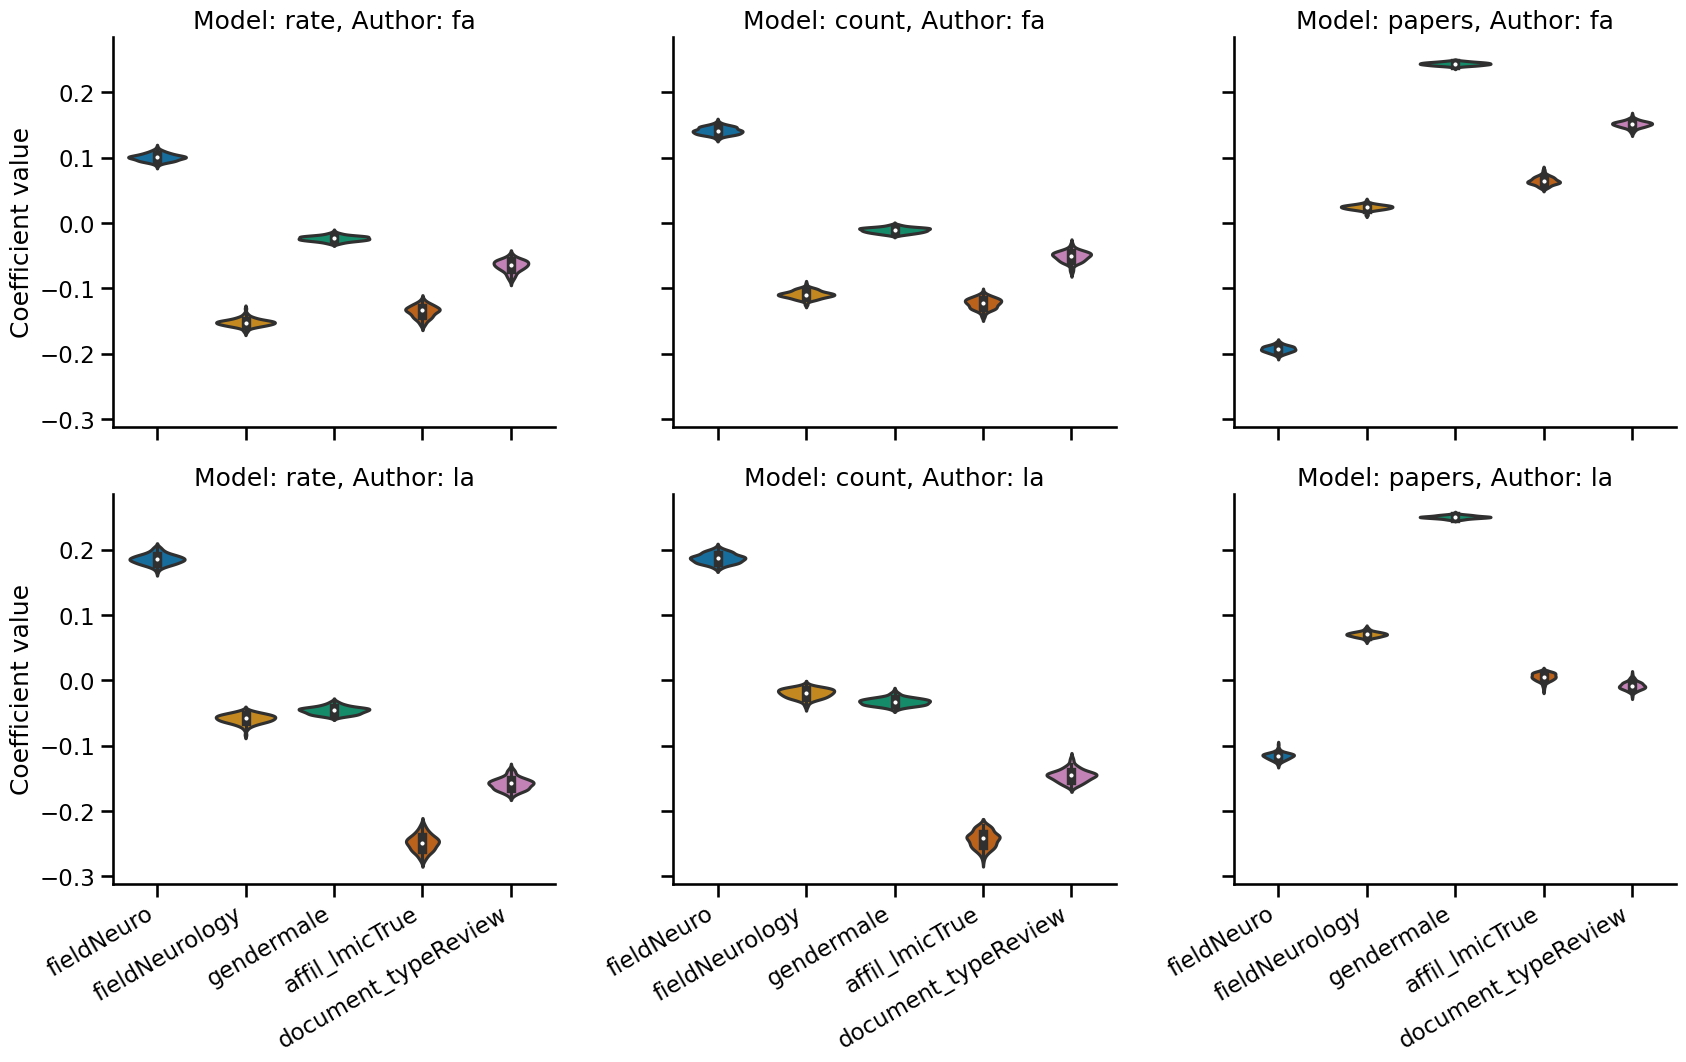

In [37]:
sns.set_context('talk')
g = sns.catplot(data=df, x='coef_name', y='coef_val',
            col='model_type', row='auth_type', aspect=1.2, kind='violin',
               palette=sns.color_palette('colorblind') )
g.set_ylabels('Coefficient value')
g.set_xlabels('')
g.set_titles("Model: {col_name}, Author: {row_name}")

# rotate tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()